Building likelihood maps for a set of representative images.

> TODO: use images from dataset and superimpose the bounding boxes on them


In [1]:
import retinoto_py as fovea
subset_factor = 50
args = fovea.Params(do_fovea=True, batch_size=1, subset_factor=subset_factor)
args

Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-7.5, angle_start=-0.7853981633974483, angle_margin=0, padding_mode='zeros', seed=2025, batch_size=1, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=41, subset_factor=50, lr=2e-07, delta1=0.2, delta2=0.007, weight_decay=0.003, label_smoothing=0.05, do_full_training=False, shuffle=True, verbose=False)

In [2]:
dataset = 'bbox'
VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, do_full_preprocess=False)
val_loader = fovea.get_loader(args, val_dataset)


In [3]:
model_filename = args.data_cache /  f'32_fovea_model_name={args.model_name}_dataset={dataset}.pth'
model = fovea.load_model(args, model_filename=model_filename)
model_filename

PosixPath('cached_data/32_fovea_model_name=convnext_base_dataset=bbox.pth')

In [4]:
# from torchvision.transforms import v2 as transforms
npz_filename = args.data_cache / '42_likelihood_maps_b.npz'

# %rm {npz_filename}  # FORCING RECOMPUTE

In [5]:
resolution = (100, 100)
resolution = (30, 30)
resolution = (7, 7)
resolution = (25, 25)
resolution = (21, 21)
size_ratio = .750
size_ratio = .45

In [6]:
from torchvision.transforms.functional import InterpolationMode, resize
image_size_full = 512

if npz_filename.exists():
    with fovea.np.load(npz_filename) as data:
        likelihood_maps_label = data['likelihood_maps_label']
        likelihood_maps_max = data['likelihood_maps_max']
        # correct_maps = data['correct_maps']
else:
    n_dataset = len(val_dataset)
    likelihood_maps_label = fovea.np.empty((resolution[0], resolution[1], n_dataset))
    likelihood_maps_max = fovea.np.empty((resolution[0], resolution[1], n_dataset))
    # correct_maps = fovea.np.empty((resolution[0], resolution[1], n_dataset))
    for i_batch, (image, true_idx) in fovea.tqdm(enumerate(val_loader), total=n_dataset):
        image, true_idx = image.to(args.device), true_idx.to(args.device)
        image = resize(image, image_size_full, interpolation=InterpolationMode.BILINEAR, antialias=True)


        image = image.squeeze(0)
        pos_H, pos_W = fovea.get_positions(image.shape[1], image.shape[2], resolution=resolution)
        probas = fovea.compute_likelihood_map(args, model, image, pos_H, pos_W, size_ratio=size_ratio)

        likelihood_maps_label[:, :, i_batch] = probas[:, true_idx].cpu().numpy().reshape(resolution)
        proba_max, _ = probas.max(axis=-1)
        likelihood_maps_max[:, :, i_batch] = proba_max.cpu().numpy().reshape(resolution)
    fovea.np.savez(npz_filename, 
        likelihood_maps_max=likelihood_maps_max,
        likelihood_maps_label=likelihood_maps_label,
        # correct_maps=correct_maps
        )   

# TODO analyse if you get a better recognition outside the center
correct_maps =  likelihood_maps_label == likelihood_maps_max

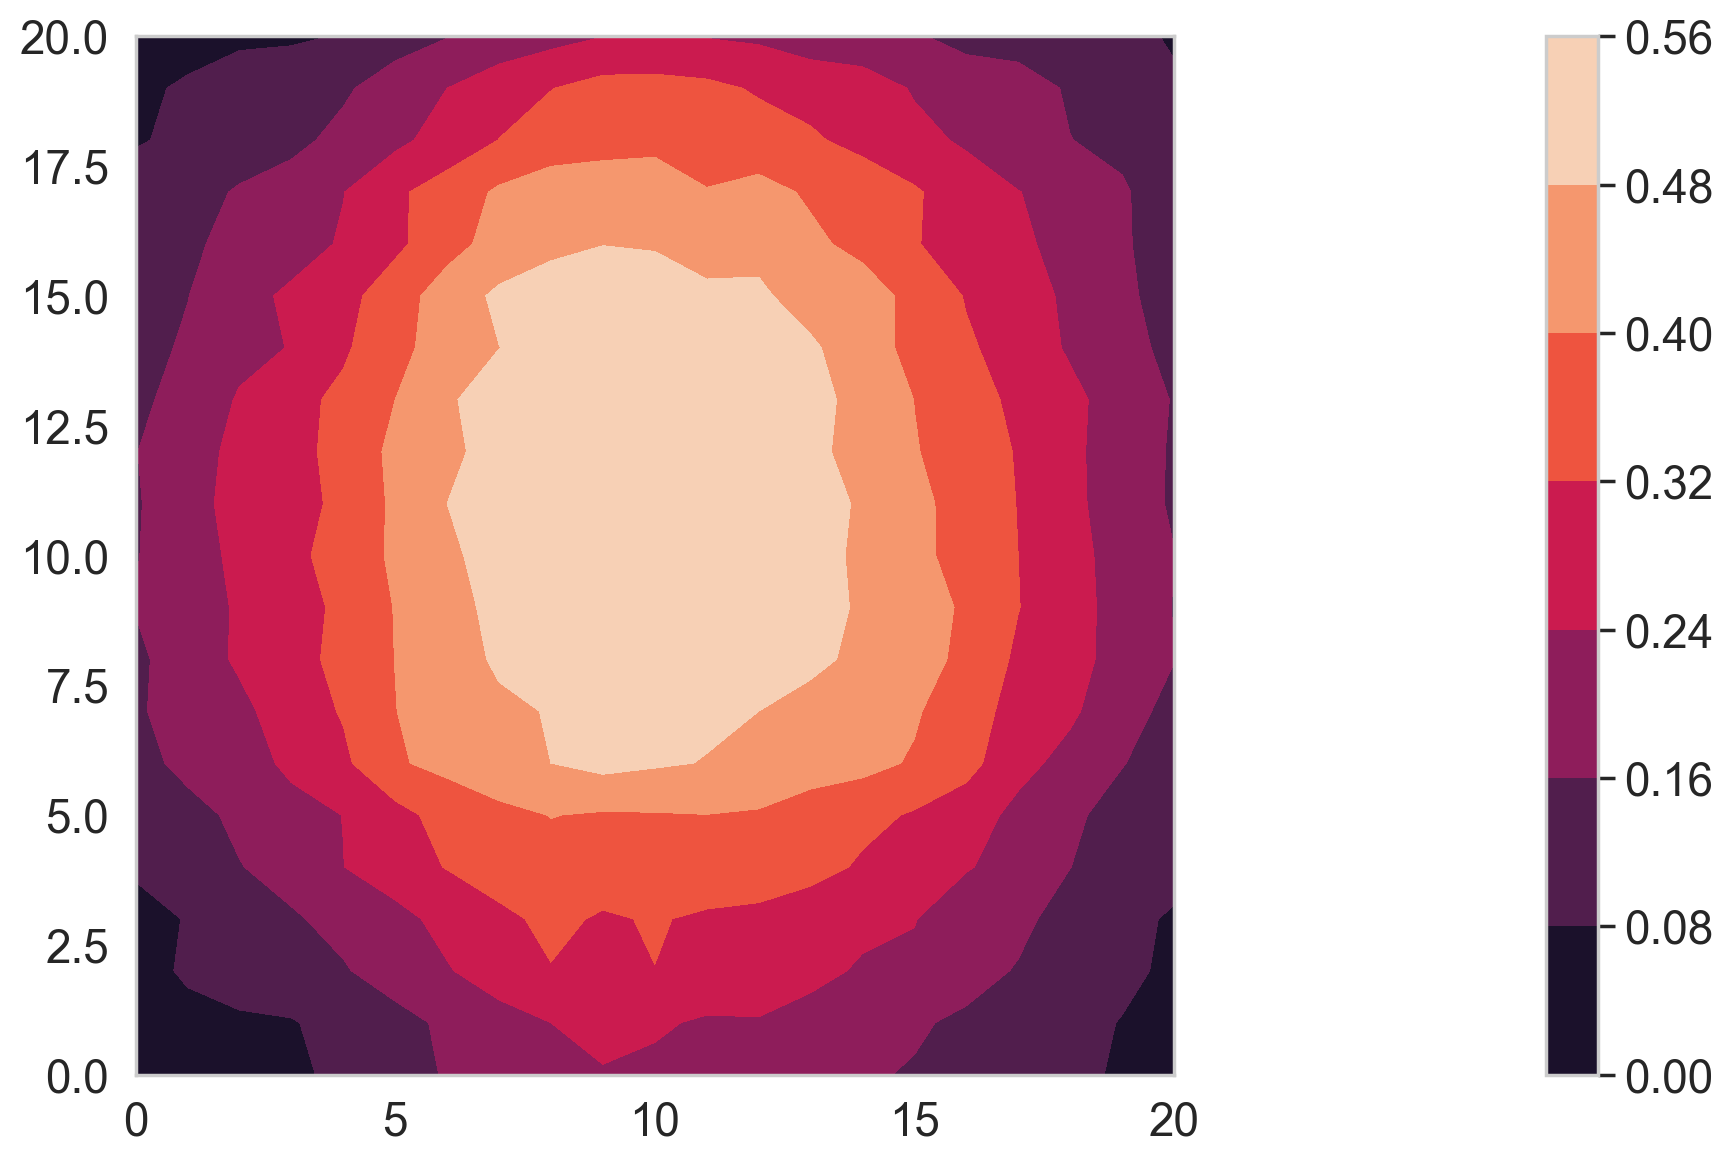

In [7]:
# TODO analyse if you get a better recognition outside the center
correct_maps =  likelihood_maps_label == likelihood_maps_max
fig, ax = fovea.plt.subplots()
contour = ax.contourf(correct_maps.mean(axis=-1))
fig.colorbar(contour, ax=ax)  # Add colorbar
ax.axis('square')
fig.set_facecolor(color='white')


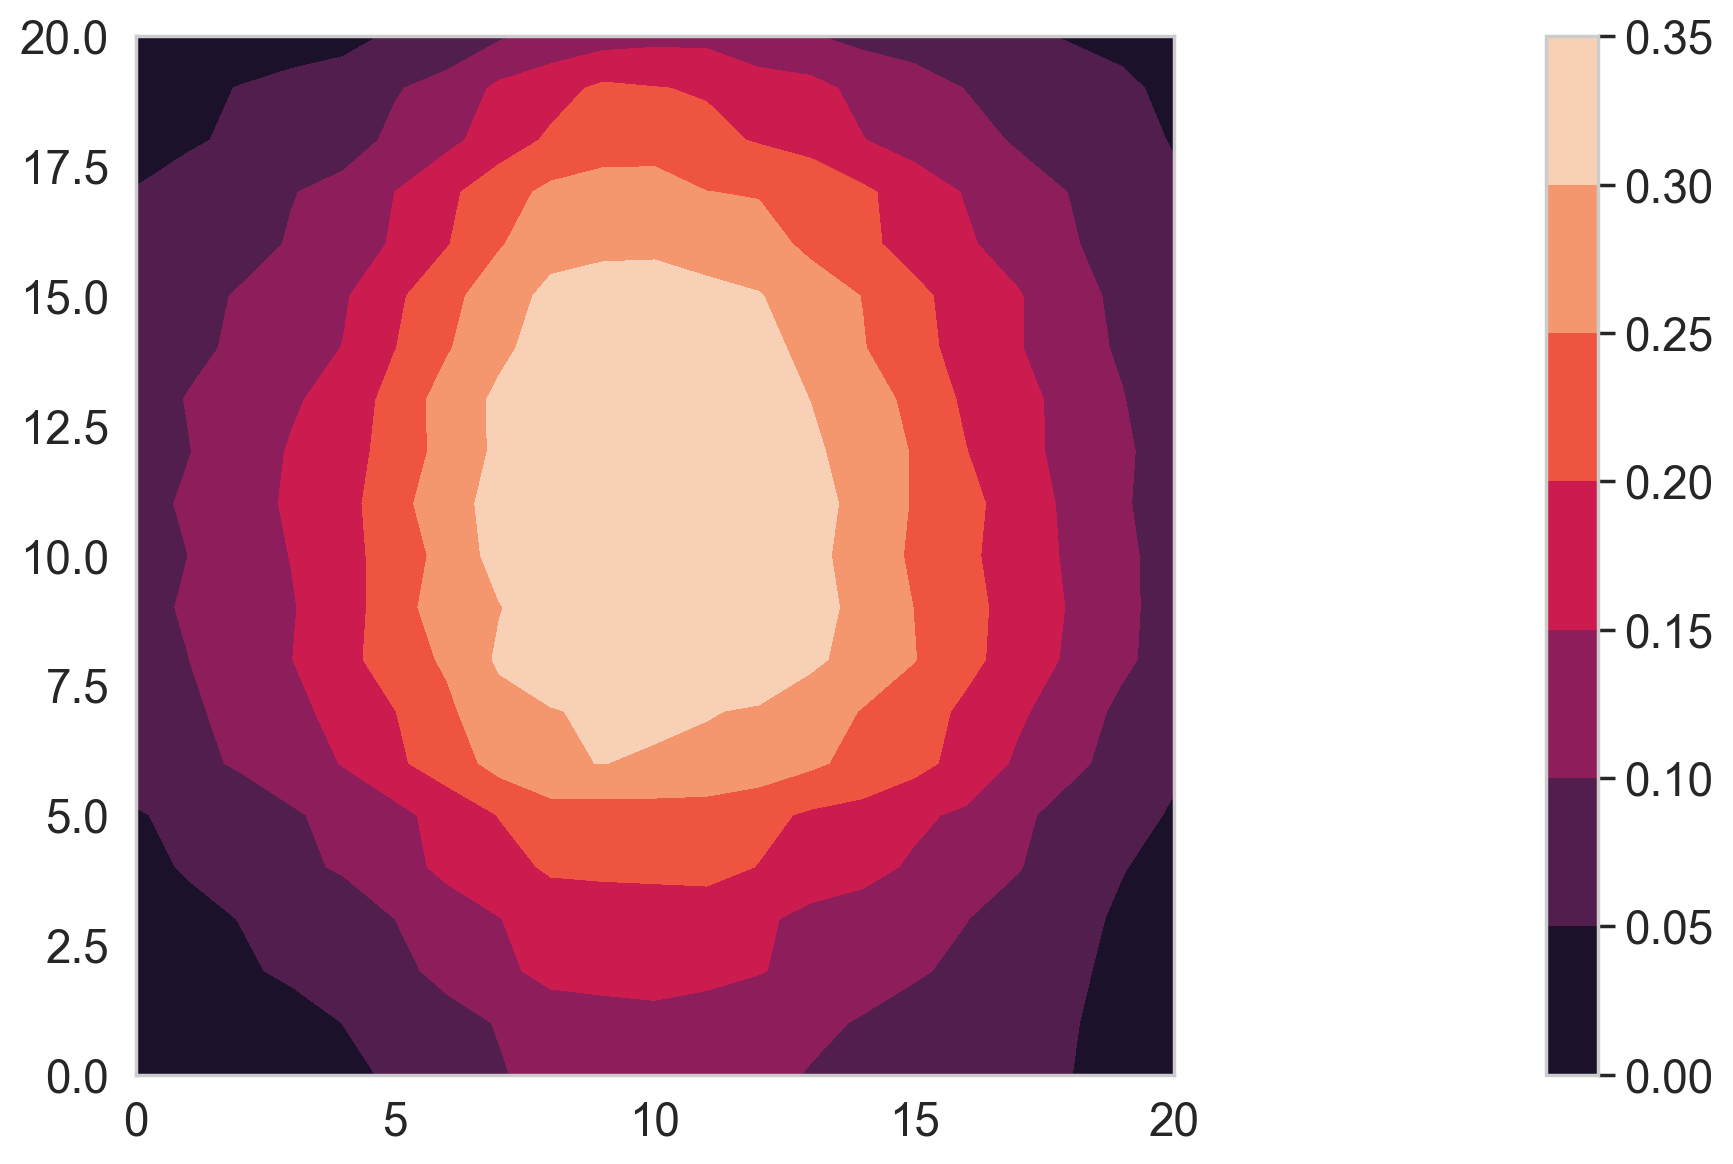

In [8]:
fig, ax = fovea.plt.subplots()
contour = ax.contourf(likelihood_maps_label.mean(axis=-1))
fig.colorbar(contour, ax=ax)  # Add colorbar
ax.axis('square')
fig.set_facecolor(color='white')


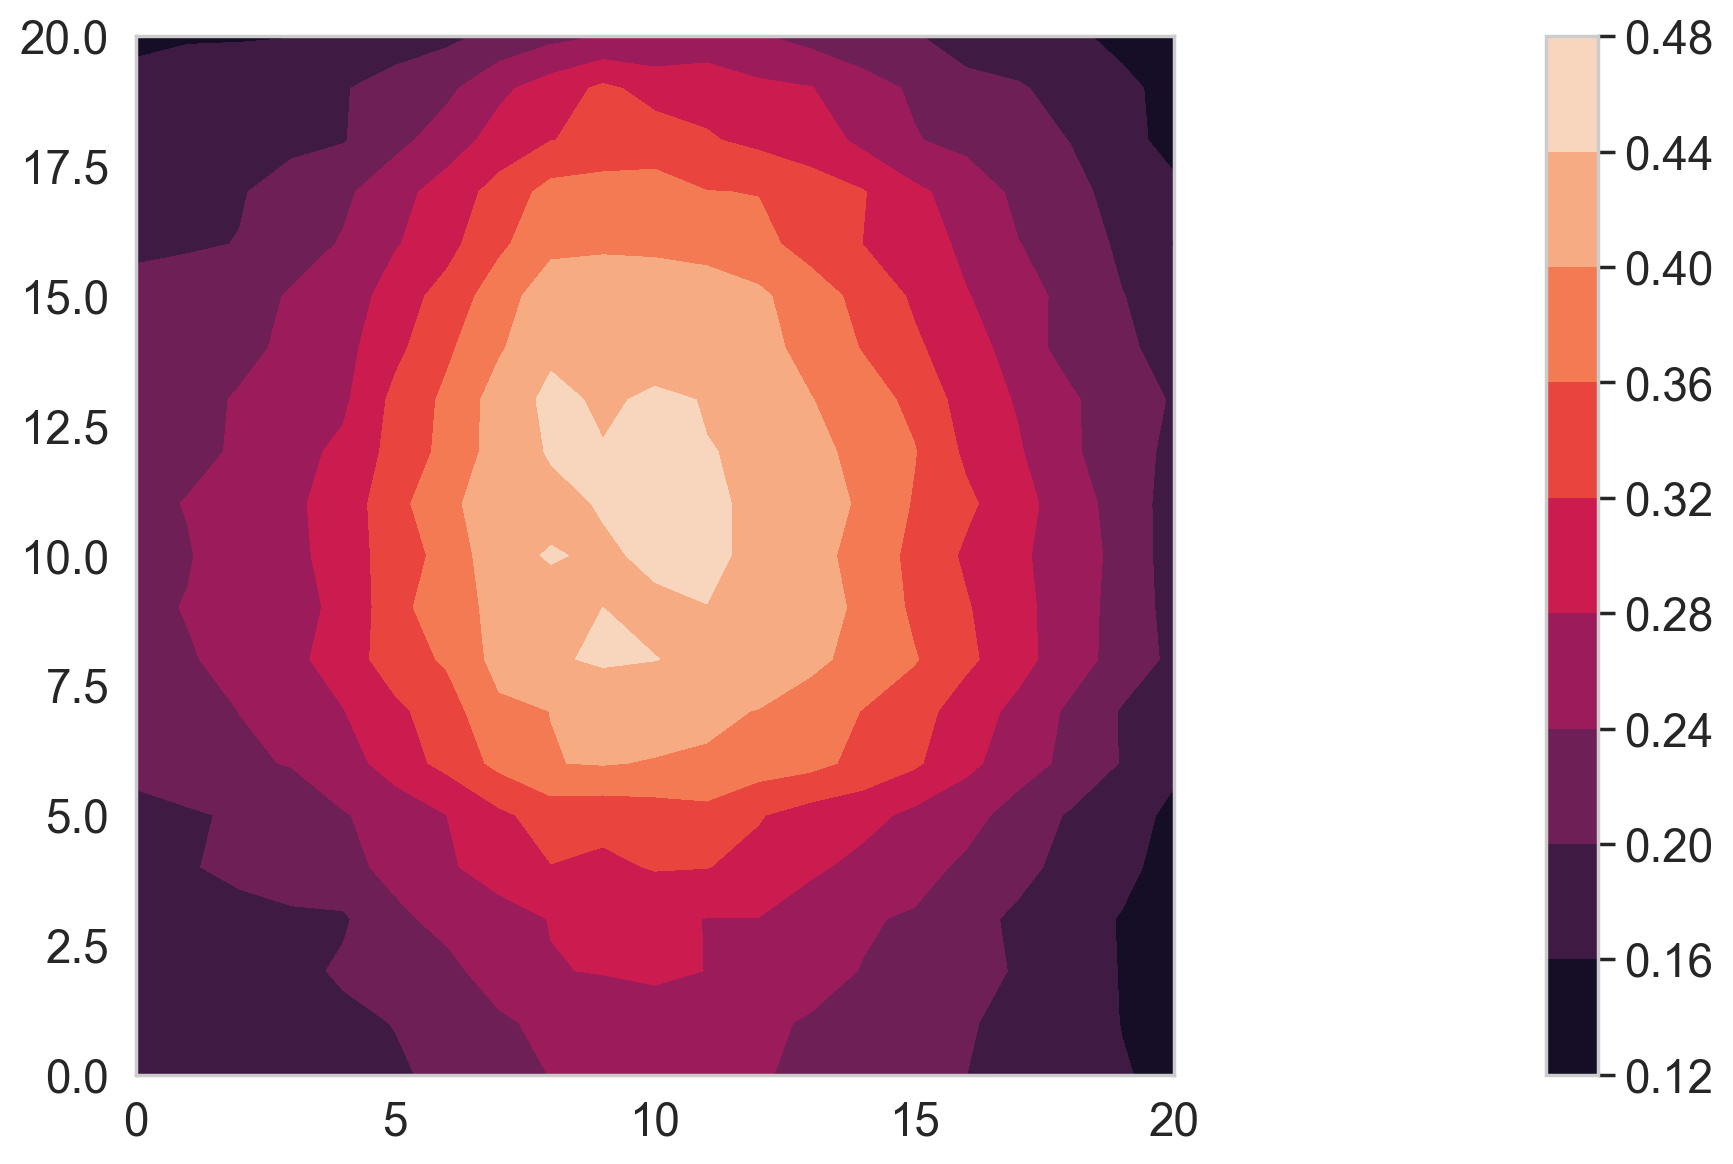

In [9]:
fig, ax = fovea.plt.subplots()
contour = ax.contourf(likelihood_maps_max.mean(axis=-1))
fig.colorbar(contour, ax=ax)  # Add colorbar
ax.axis('square')
fig.set_facecolor(color='white')


In [10]:
# i_image = 2
# proba = likelihood_maps[:, :, i_image]
# proba.min(), proba.max()

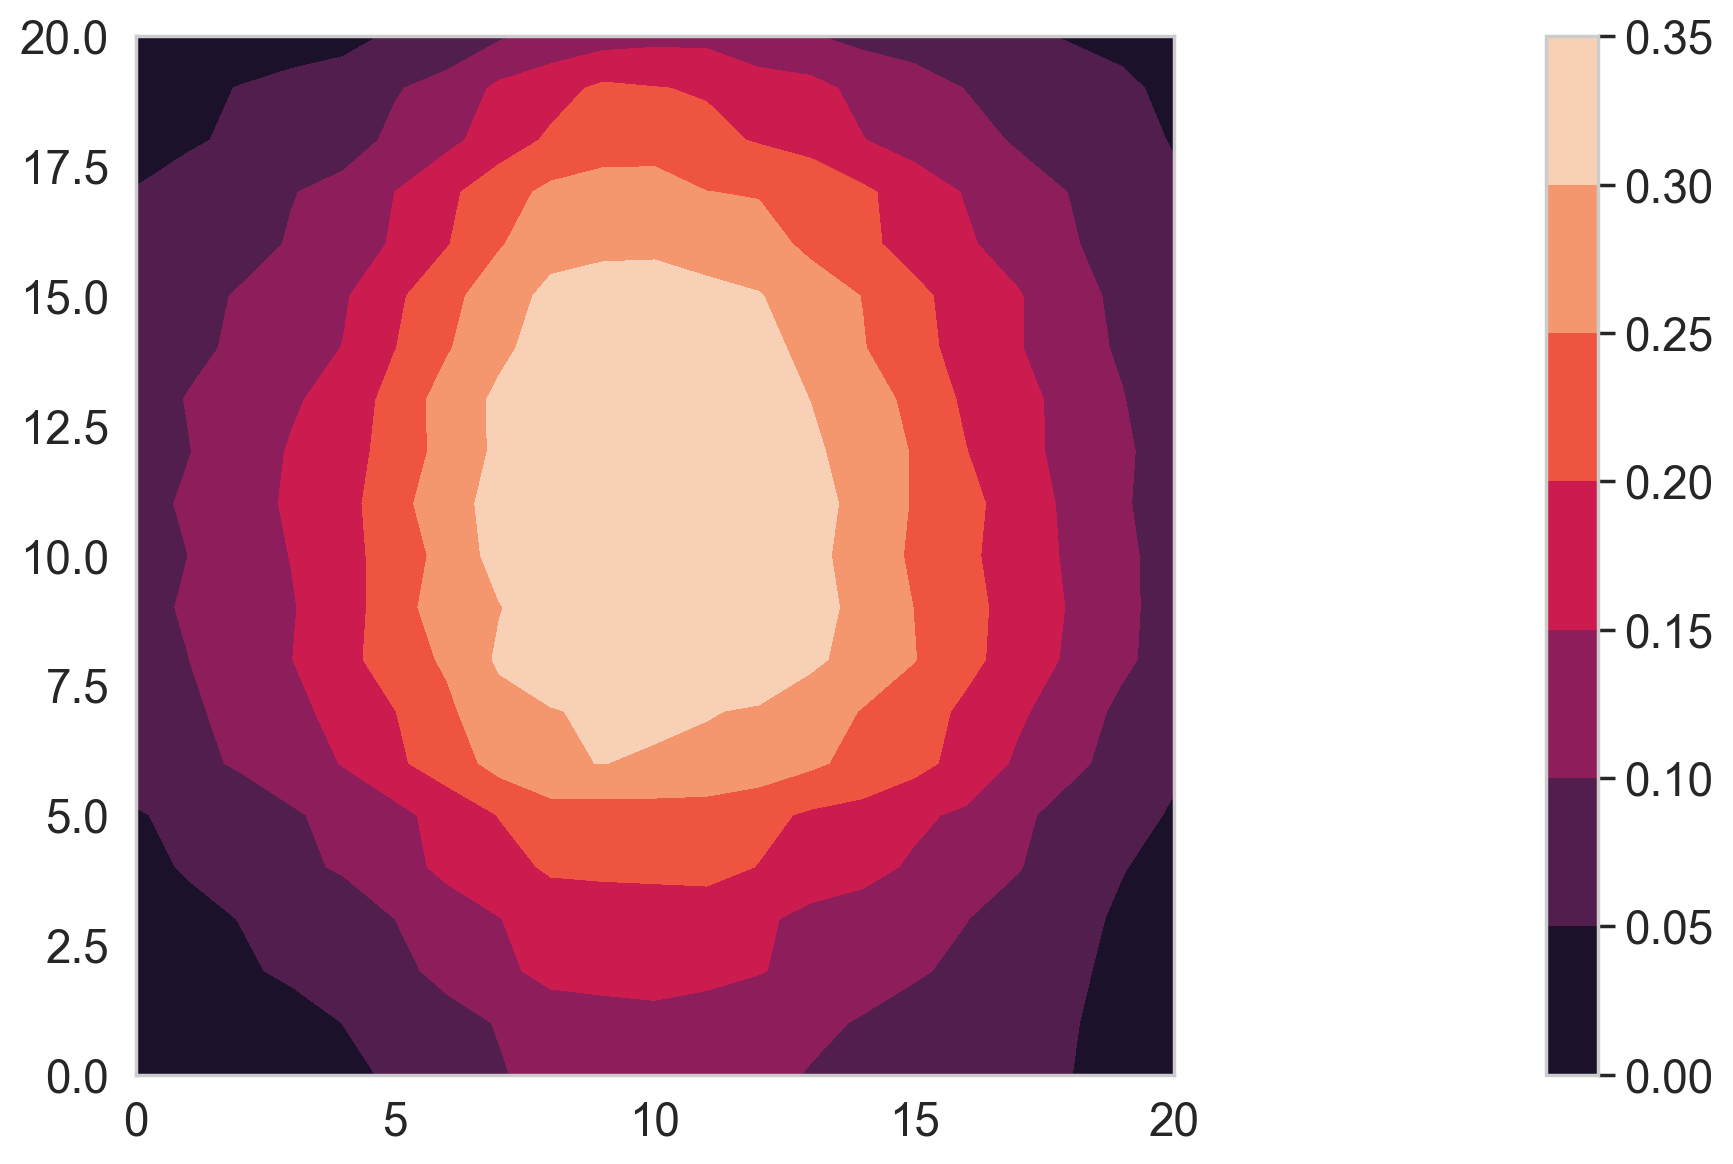

In [11]:
fig, ax = fovea.plt.subplots()
contour = ax.contourf(likelihood_maps_label.mean(axis=-1))
fig.colorbar(contour, ax=ax)  # Add colorbar
ax.axis('square')
fig.set_facecolor(color='white')


[Text(0.5, 0, 'likelihood'),
 Text(0.5, 1.0, 'distribution of maximal label likelihoods')]

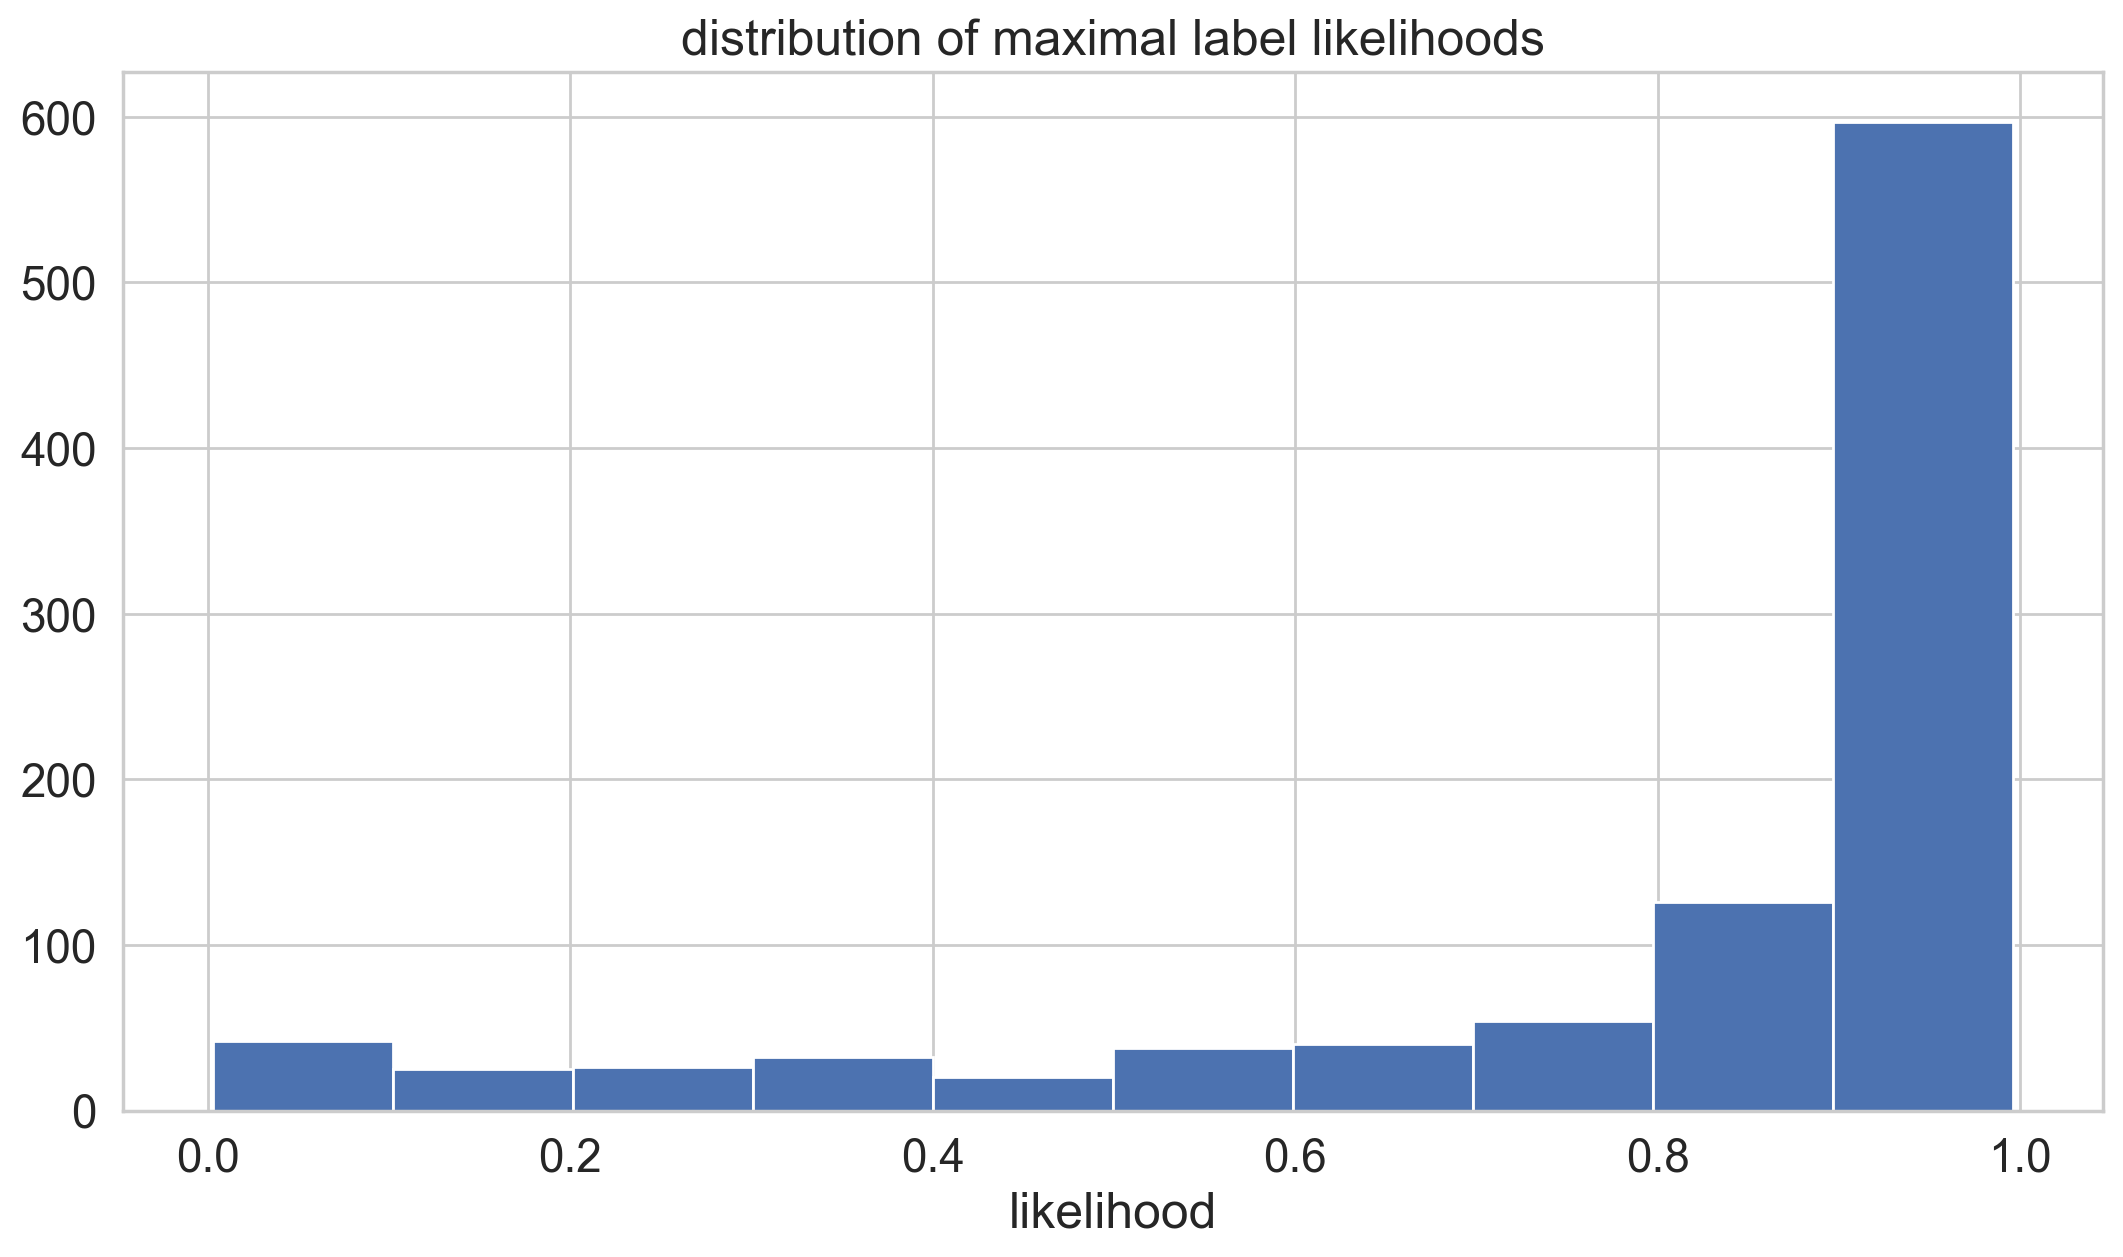

In [12]:
accuracy = likelihood_maps_label.max(axis=(0, 1))
fig, ax = fovea.plt.subplots()
ax.hist(accuracy)
ax.set(xlabel='likelihood', title='distribution of maximal label likelihoods')

In [13]:
import pandas as pd
import numpy as np
pos_H, pos_W = fovea.get_positions(1, 1, resolution=resolution)
pos_H.min(), pos_H.max(), pos_W.min(), pos_W.max(), pos_H.shape, likelihood_maps_label.shape

(np.float64(0.045454545454545456),
 np.float64(0.9545454545454546),
 np.float64(0.05681818181818182),
 np.float64(0.9659090909090909),
 (441,),
 (21, 21, 1000))

In [14]:
# data = []
# for do_fovea in [True, False]:    
#     likelihood_maps = fovea.np.load(npy_filename)
#     data_= pd.DataFrame({
#         'horizontal position': pos_H,
#         'vertical position': pos_W,
#         'probas': likelihood_maps.mean(axis=-1).T.flatten(),
#         'retinotopy': 'foveated' if do_fovea else 'uniform' 
#     })
#     data.append(data_)
# combined_data = pd.concat(data, ignore_index=True)
# combined_data

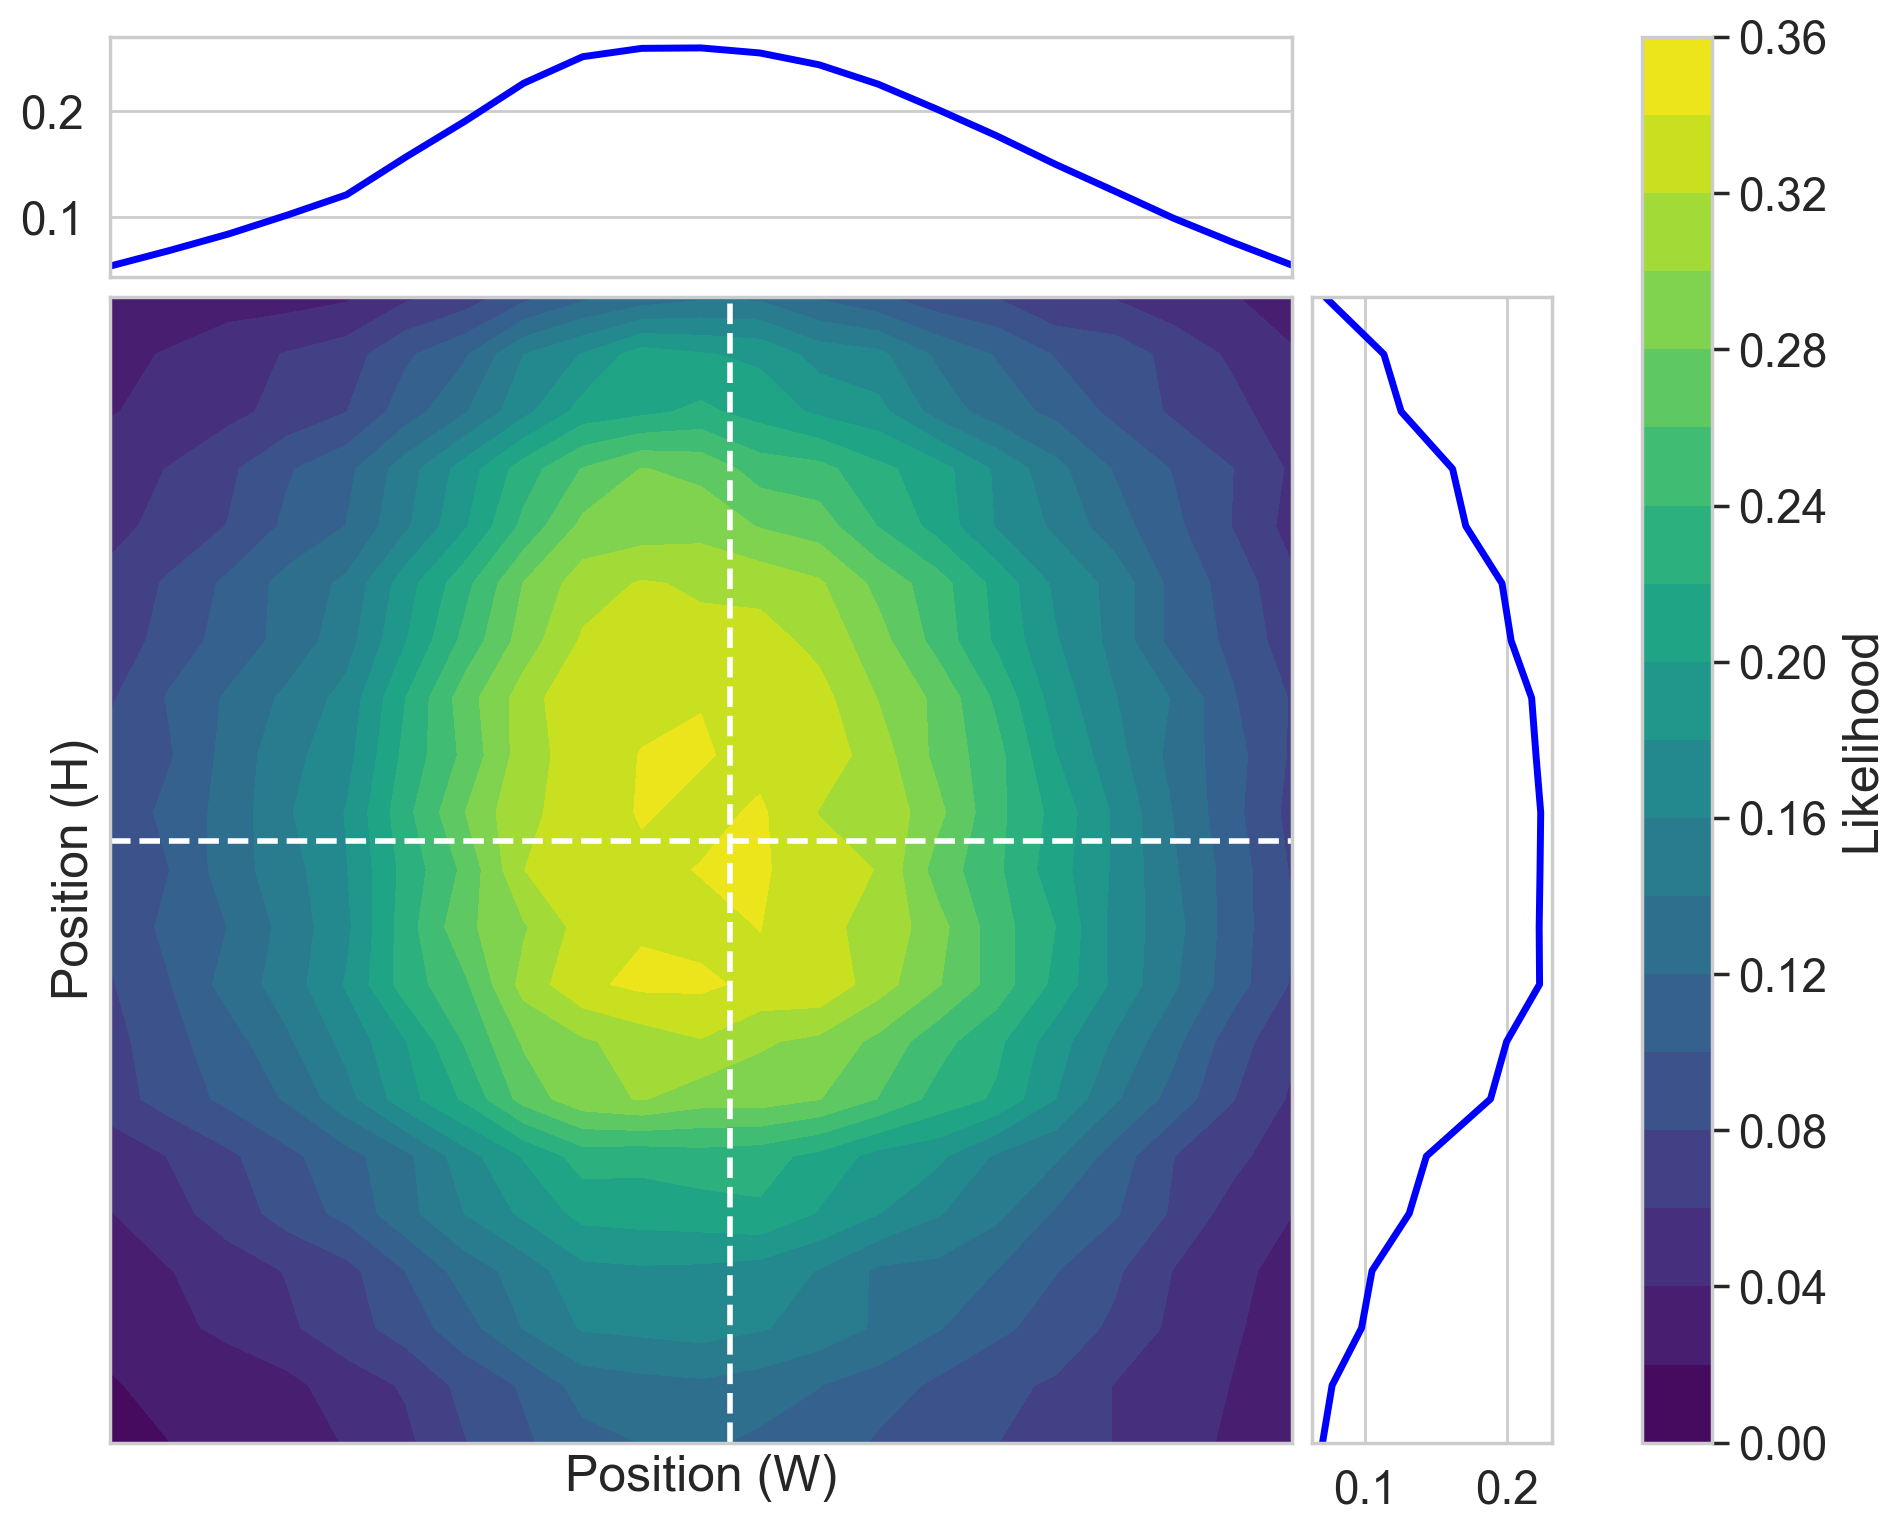

In [15]:

fig, axes = fovea.visualize_likelihood_map(likelihood_maps_label.mean(axis=-1))


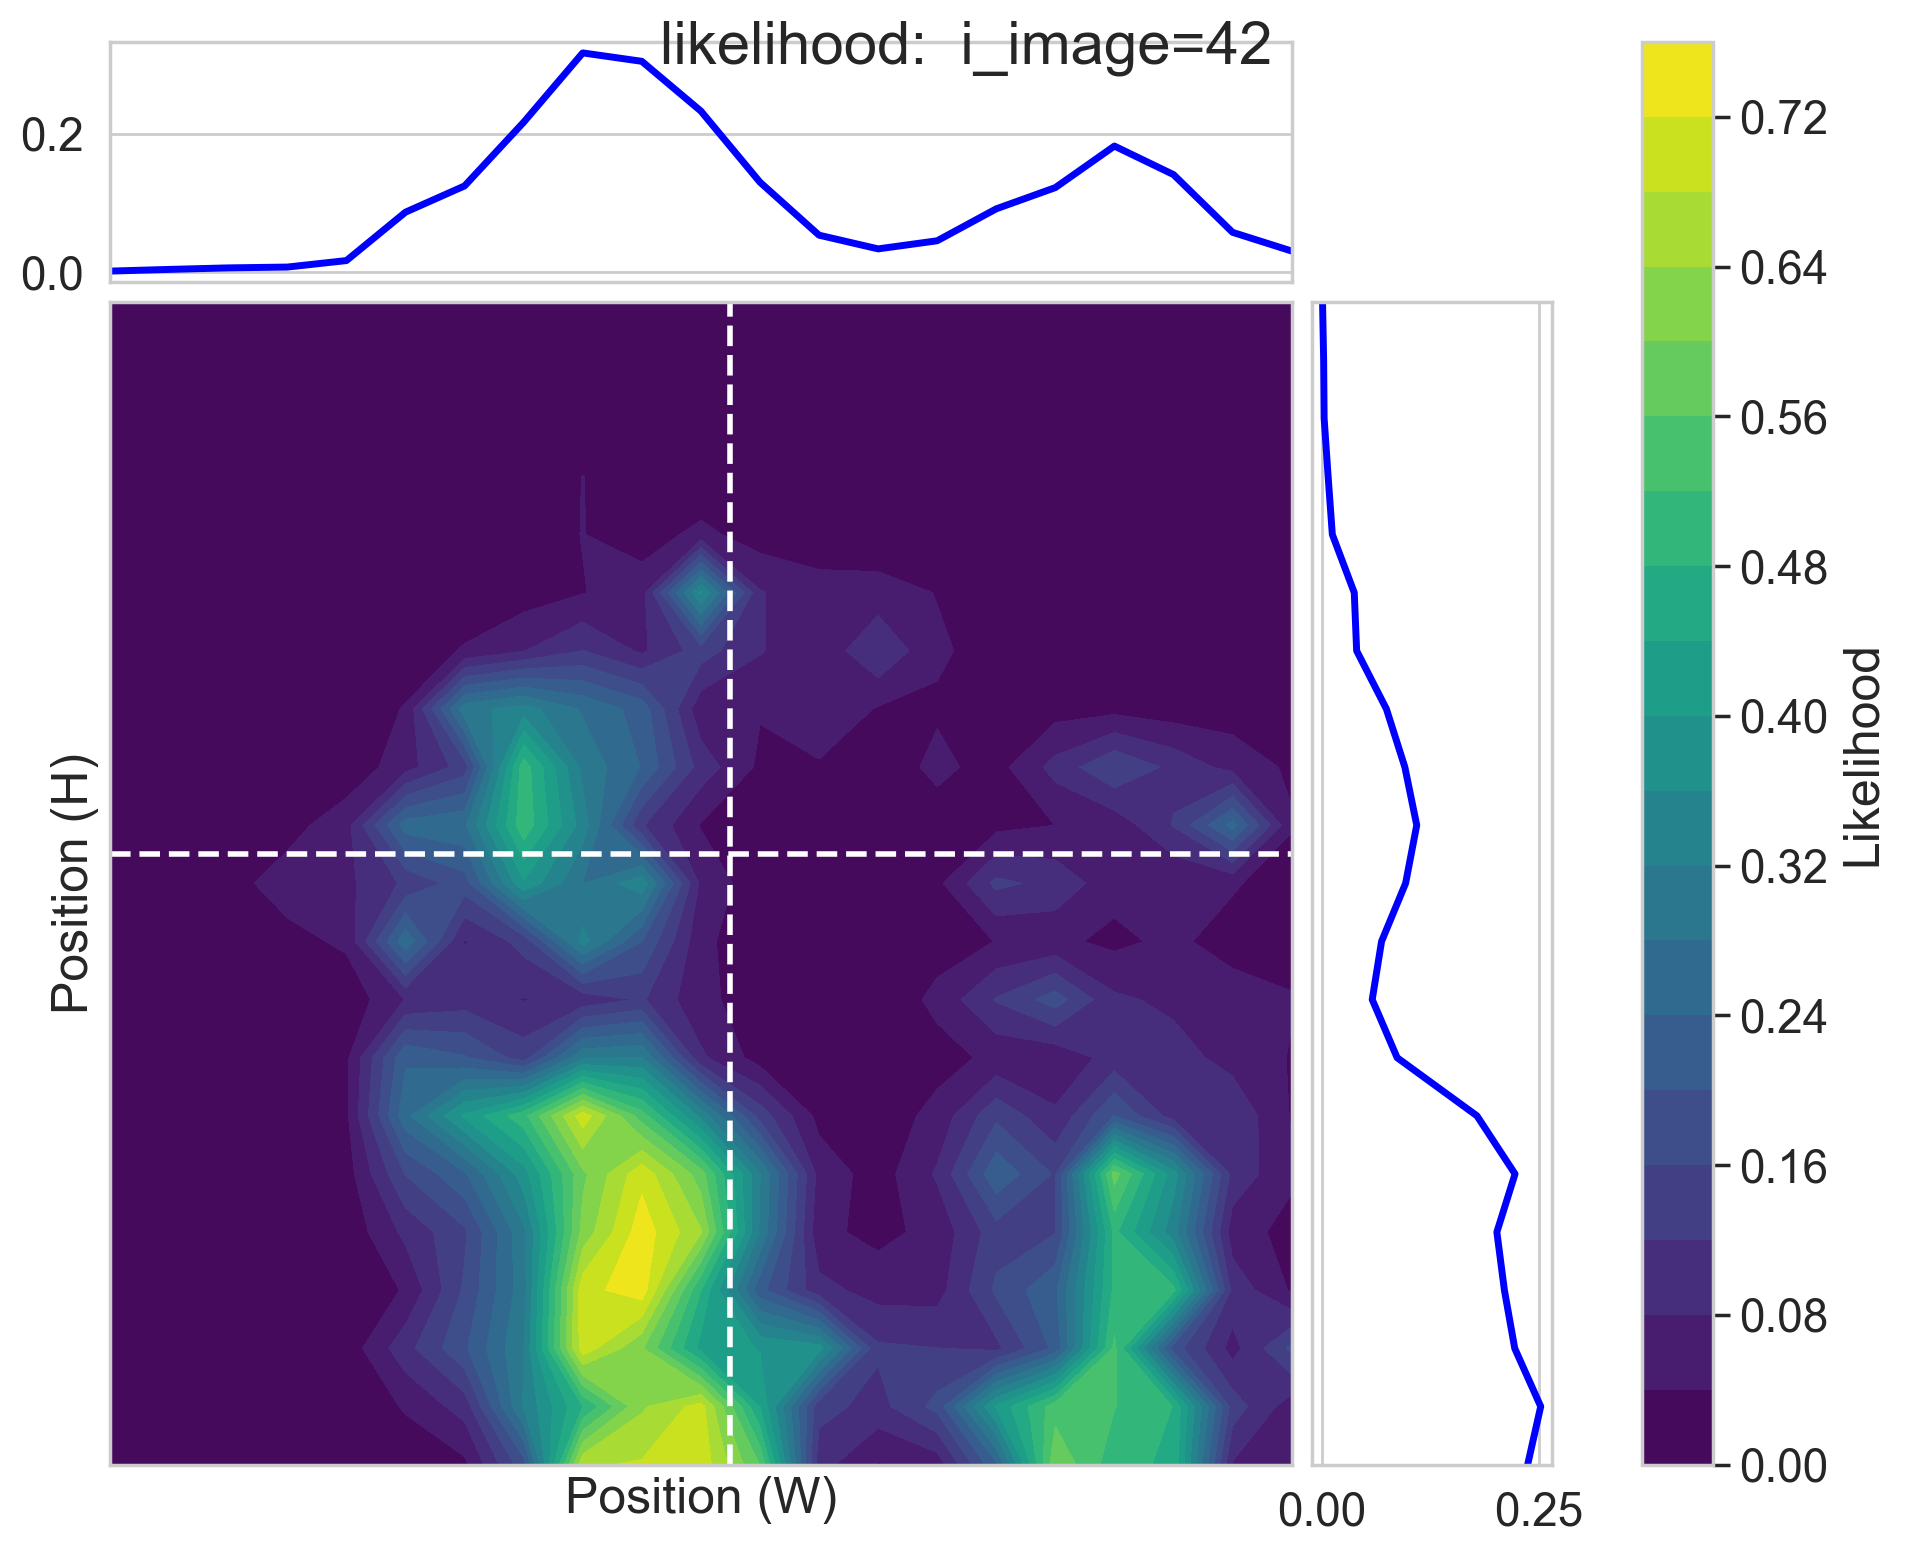

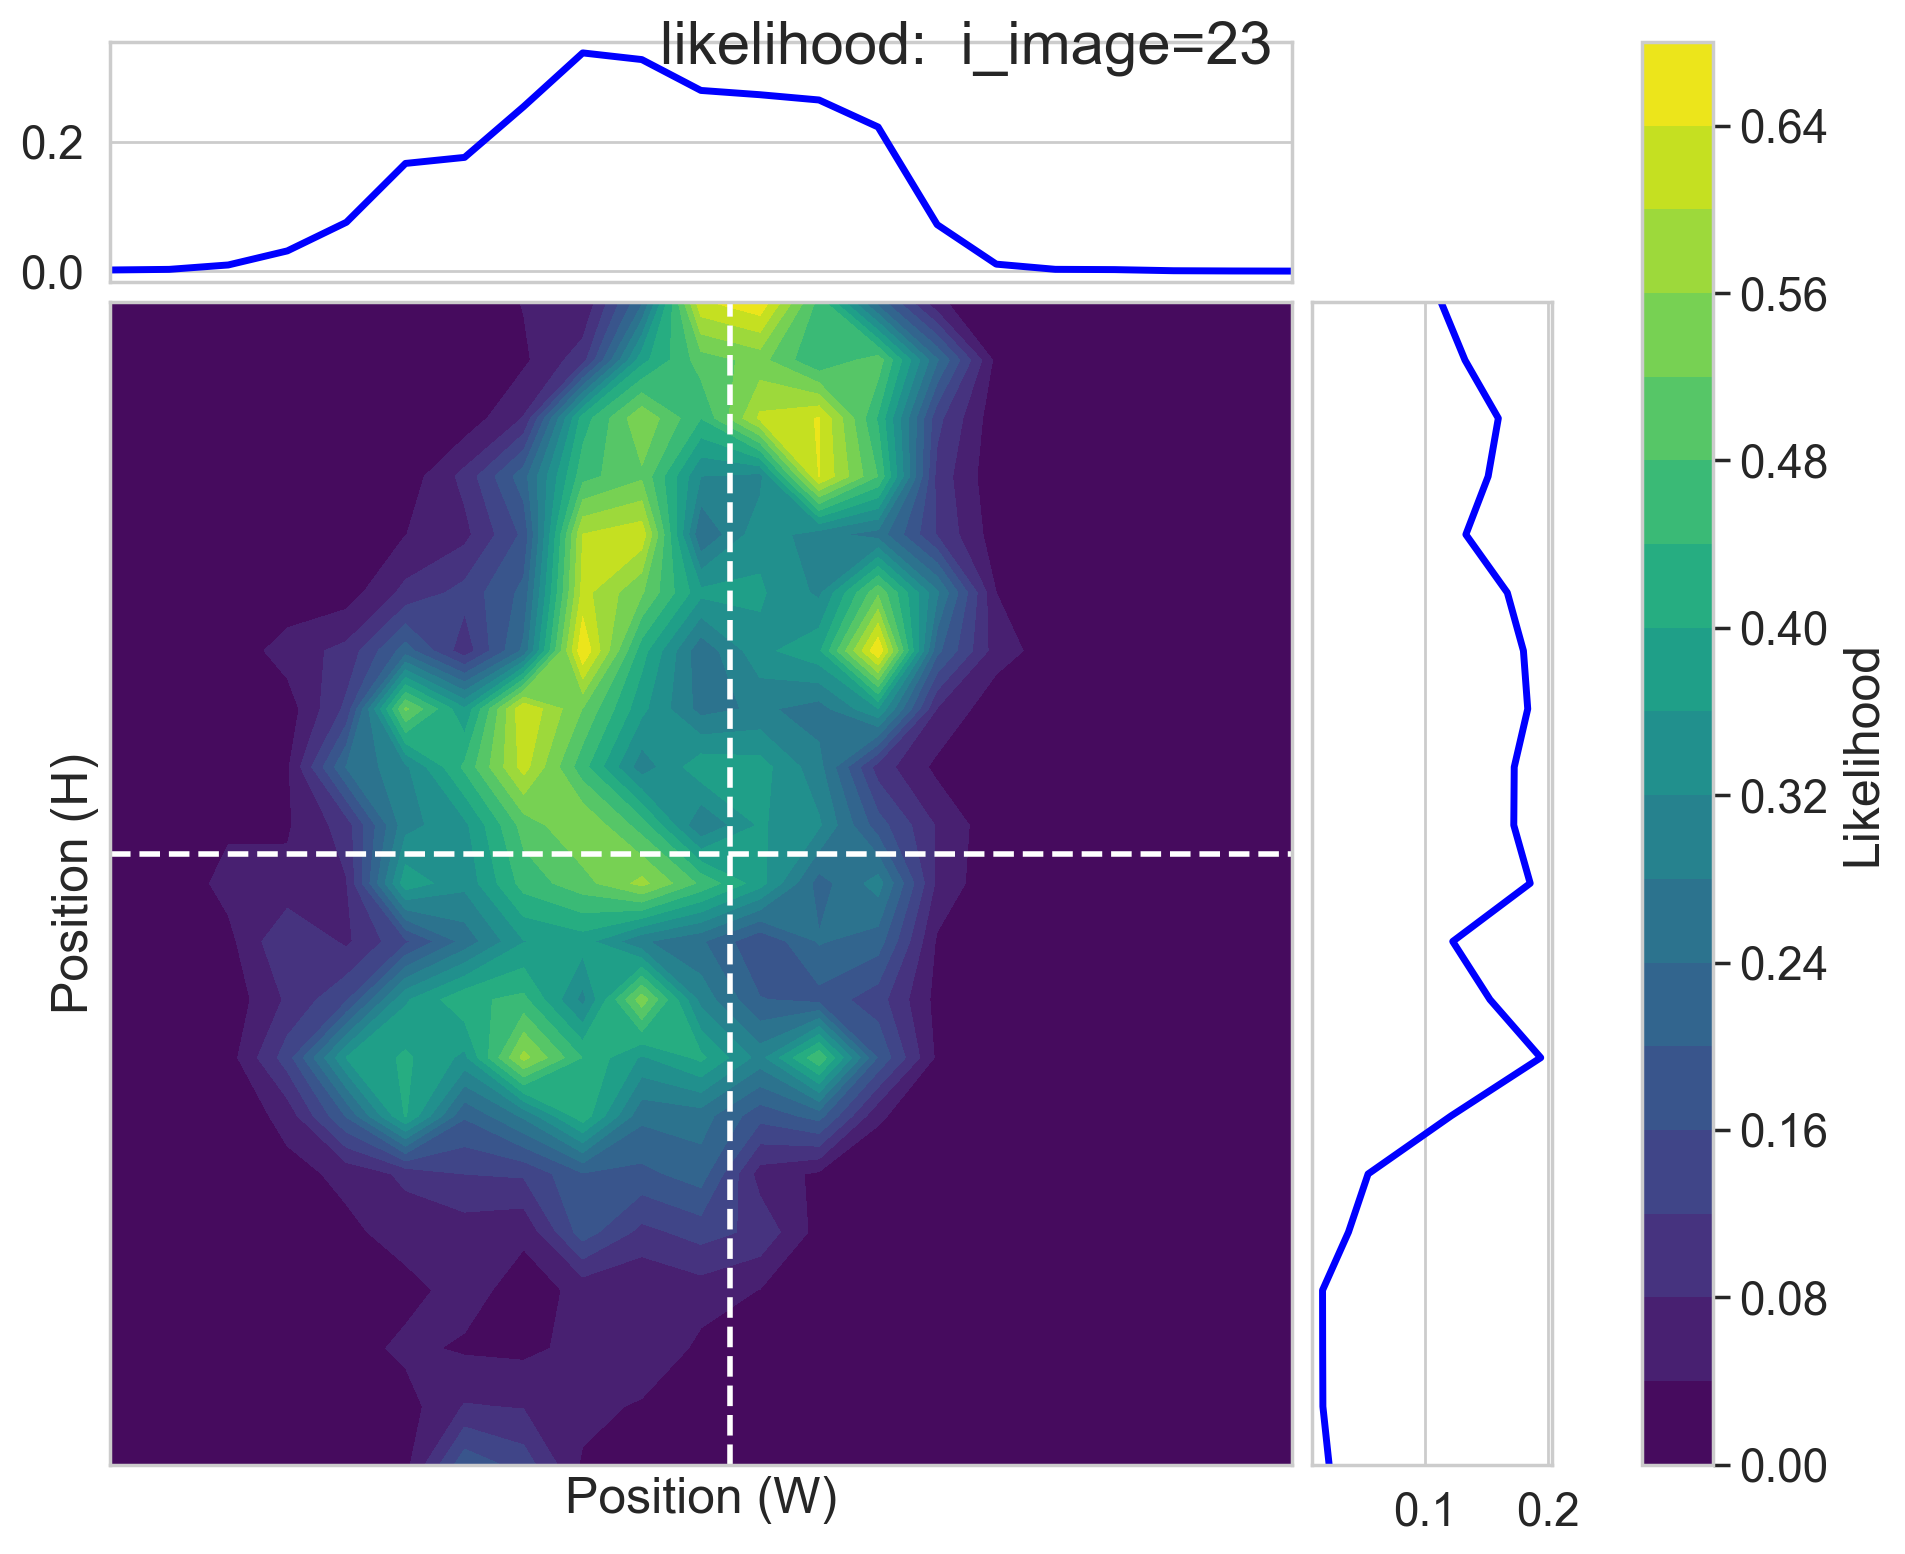

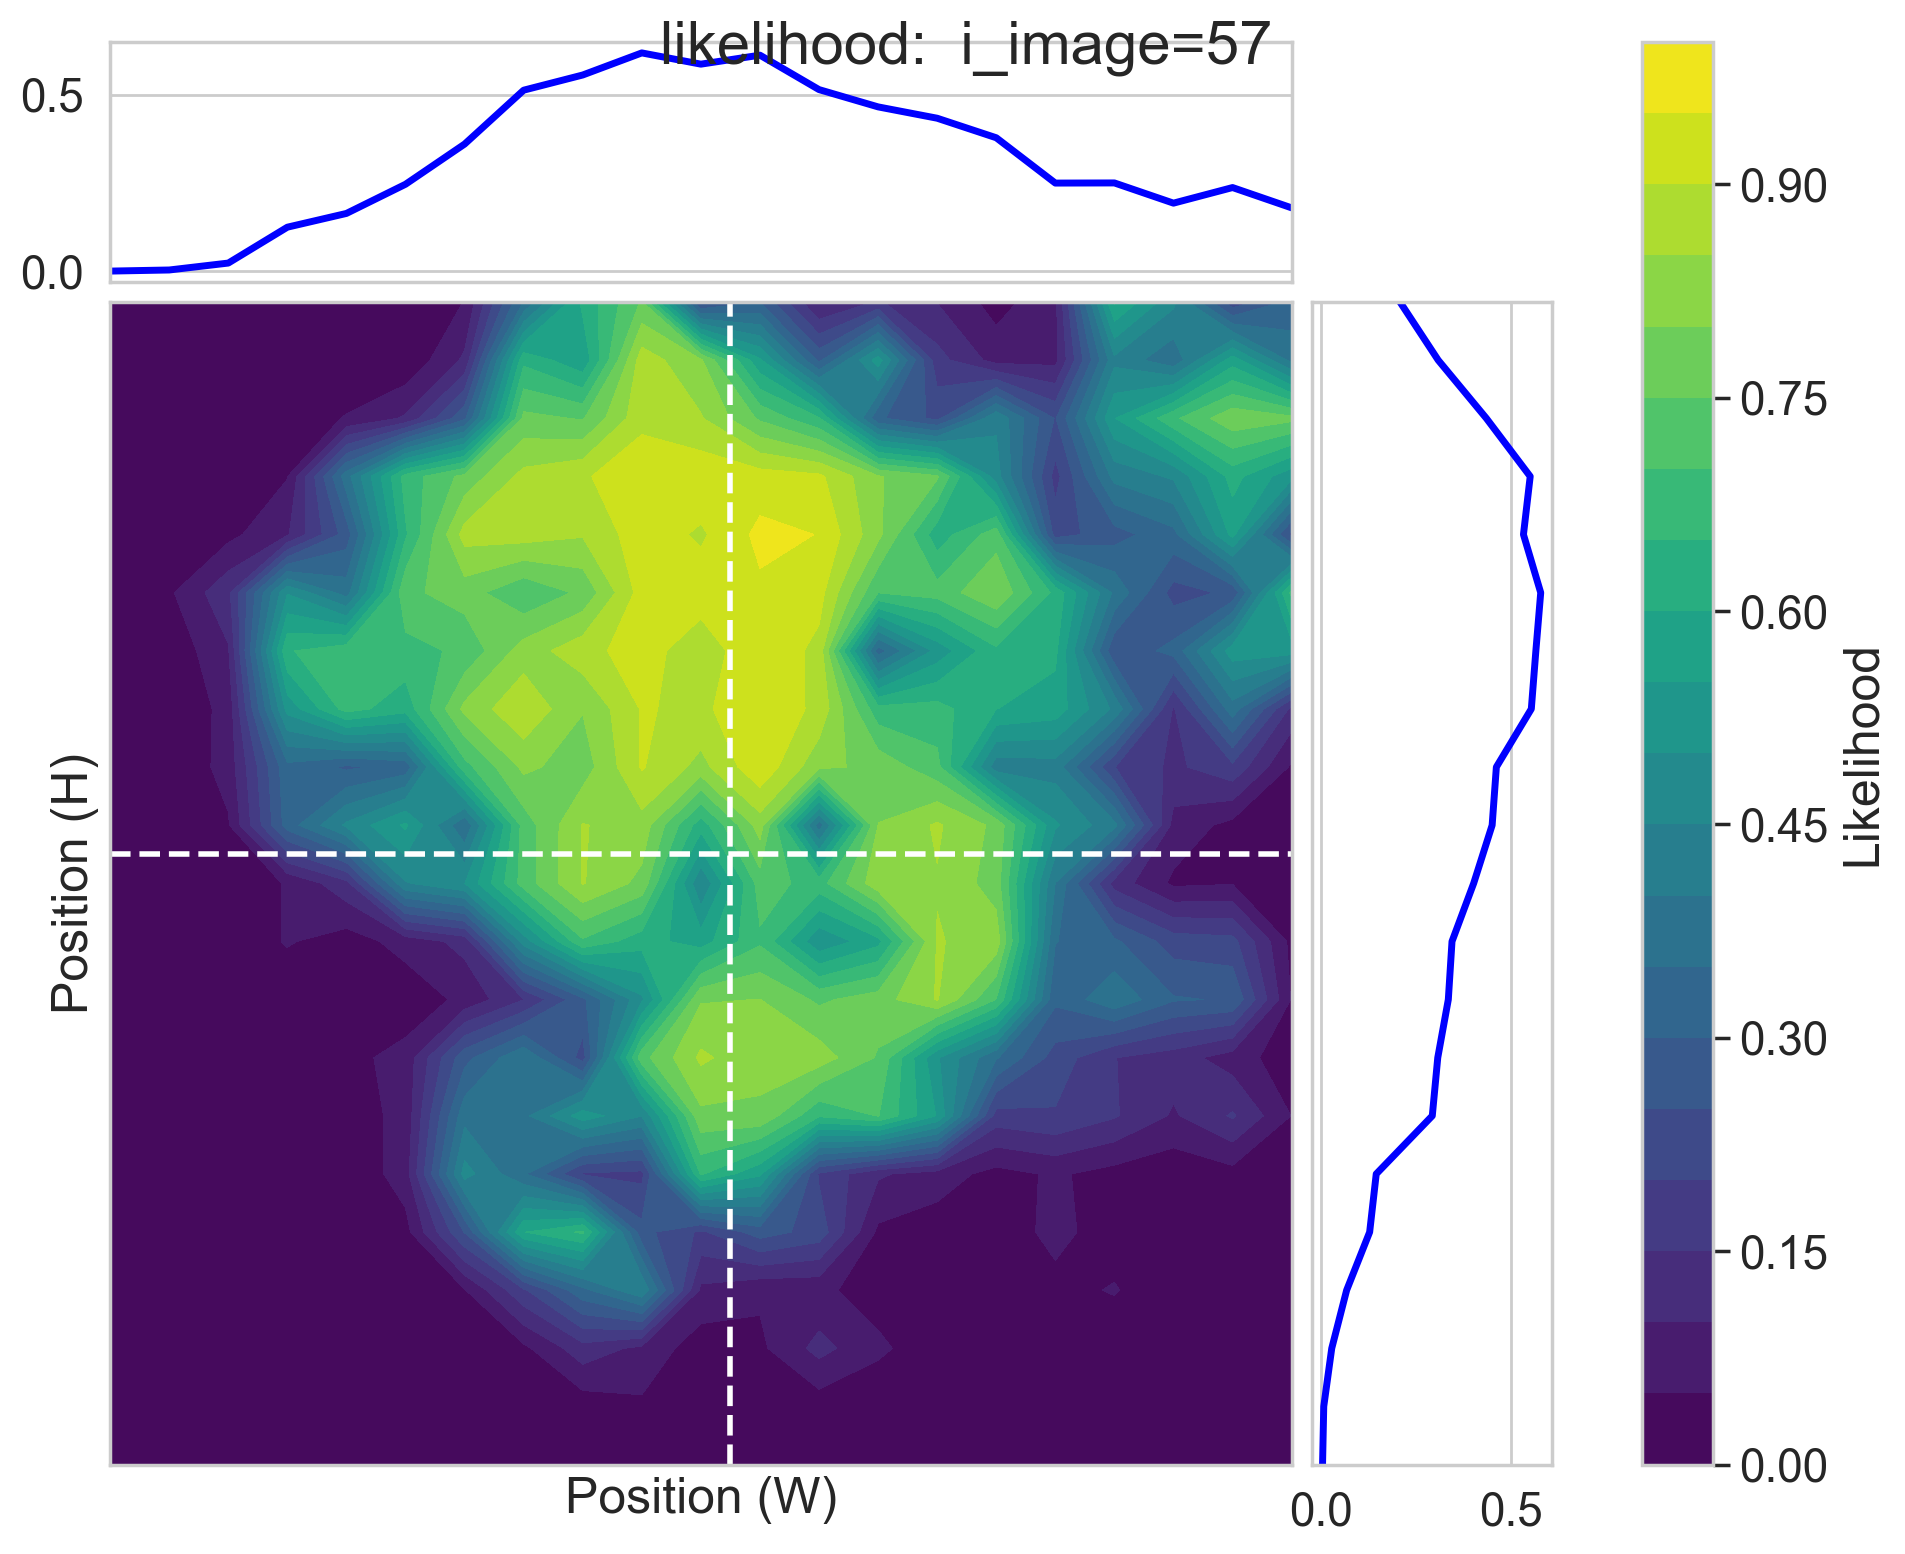

In [16]:
for i_image in [42, 23, 57]:
    fig, axes = fovea.visualize_likelihood_map(likelihood_maps_label[:, :, i_image], sigma=.5)
    fig.suptitle(f'likelihood:  {i_image=}')

    fovea.plt.show()

In [17]:
# from scipy.optimize import curve_fit

# def gaussian_2d(x, y, amplitude, x0, y0, sigma_x, sigma_y, theta):
#     """
#     2D Gaussian function with rotation (theta).
#     """
#     a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
#     b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
#     c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
#     return amplitude * np.exp(-(a*((x-x0)**2) + 2*b*(x-x0)*(y-y0) + c*((y-y0)**2)))

# from scipy.optimize import curve_fit

# def fit_gaussian(likelihood_map):
#     """
#     Fit a 2D Gaussian to a likelihood map, constraining x0 and y0 to [-1, 1].
#     Returns: amplitude, x0, y0, sigma_x, sigma_y, theta (rotation angle)
#     """
#     # Create a grid of coordinates
#     ny, nx = likelihood_map.shape
#     x = np.linspace(-1, 1, nx)
#     y = np.linspace(-1, 1, ny)
#     x, y = np.meshgrid(x, y)

#     # Flatten the likelihood map and coordinates
#     data = likelihood_map.flatten()
#     x_flat = x.flatten()
#     y_flat = y.flatten()

#     # Initial guess for parameters
#     initial_guess = (
#         np.max(likelihood_map),  # amplitude
#         0,                       # x0 (middle of the map)
#         0,                       # y0
#         0.9,                     # sigma_x
#         0.9,                     # sigma_y
#         0                        # theta (no rotation)
#     )

#     # Define bounds: (x0, y0) must be in [-1, 1]
#     # Format: ([min_amp, min_x0, min_y0, min_sx, min_sy, min_theta], [max_amp, max_x0, max_y0, max_sx, max_sy, max_theta])
#     bounds = (
#         [-np.inf, -1, -1, 0.01, 0.01, -np.pi],  # Lower bounds
#         [np.inf, 1, 1, 2, 2, np.pi]            # Upper bounds
#     )

#     # Fit the Gaussian with bounds
#     try:
#         popt, pcov = curve_fit(
#             lambda arr, amp, x0, y0, sx, sy, theta:
#                 gaussian_2d(arr[0], arr[1], amp, x0, y0, sx, sy, theta),
#             (x_flat, y_flat),
#             data,
#             p0=initial_guess,
#             bounds=bounds,
#             maxfev=100000
#         )
#         return popt
#     except RuntimeError:
#         # If fitting fails, return NaN values
#         return np.full(6, np.nan)

# import pandas as pd

# def compute_gaussian_params(likelihood_maps):
#     """
#     Compute Gaussian parameters for each likelihood map in `likelihood_maps`.
#     `likelihood_maps` shape: (height, width, n_images)
#     Returns: pandas DataFrame with columns for each parameter
#     """
#     n_images = likelihood_maps.shape[-1]
#     results = {
#         'image_index': [],
#         'amplitude': [],
#         'x0': [],
#         'y0': [],
#         'sigma_x': [],
#         'sigma_y': [],
#         'theta': []
#     }

#     for i_image in fovea.tqdm(range(n_images)):
#         likelihood_map = likelihood_maps[:, :, i_image]
#         # Smooth the map to reduce noise
#         likelihood_map = gaussian_filter(likelihood_map, sigma=1)
#         # Fit the Gaussian
#         gaussian_params = fit_gaussian(likelihood_map)

#         # Append results to the dictionary
#         results['image_index'].append(i_image)
#         results['amplitude'].append(gaussian_params[0])
#         results['x0'].append(gaussian_params[1])
#         results['y0'].append(gaussian_params[2])
#         results['sigma_x'].append(gaussian_params[3])
#         results['sigma_y'].append(gaussian_params[4])
#         results['theta'].append(gaussian_params[5])

#     # Convert the dictionary to a pandas DataFrame
#     df = pd.DataFrame(results)
#     return df


# # Example usage:
# gaussian_df = compute_gaussian_params(likelihood_maps)
# gaussian_df.head()

In [18]:
# # Joint KDE plot with marginals
# g = fovea.sns.jointplot(
#     data=gaussian_df,
#     x="x0",
#     y="y0",
#     kind="kde",
#     cmap="viridis",
# )
# plt.show()

In [19]:
gaussian_df = fovea.compute_gaussian_params(likelihood_maps_label, sigma=.5)
gaussian_df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,amplitude,x0,y0,sigma_x,sigma_y,theta,theta_deg,sigma_major,sigma_minor,elongation,sigma
0,0.552694,-0.127164,-1.000000,0.303354,2.659142,-0.013250,-0.759165,2.659142,0.303354,8.765793,0.898144
1,0.941917,0.708146,-0.585361,0.283732,1.967197,-0.583294,-33.420283,1.967197,0.283732,6.933285,0.747099
2,0.777321,0.078024,0.054126,0.377425,1.192865,0.123884,7.098059,1.192865,0.377425,3.160532,0.670982
3,0.601253,-0.098899,-0.299400,0.663968,0.372974,-0.782355,-44.825635,0.663968,0.372974,1.780197,0.497637
4,0.195751,-0.052812,-0.051100,0.021215,0.025663,0.002091,0.119798,0.025663,0.021215,1.209673,0.023333


In [20]:
# Example: Check if sigma_x is usually bigger than sigma_y
is_sigma_x_bigger = gaussian_df["sigma_x"] > gaussian_df["sigma_y"]
print(f"Fraction of images where sigma_x > sigma_y (more horizontal): {is_sigma_x_bigger.mean():.2f}")
print(f"Fraction of images where sigma_y > sigma_x (more vertical): {(~is_sigma_x_bigger).mean():.2f}")

Fraction of images where sigma_x > sigma_y (more horizontal): 0.39
Fraction of images where sigma_y > sigma_x (more vertical): 0.61


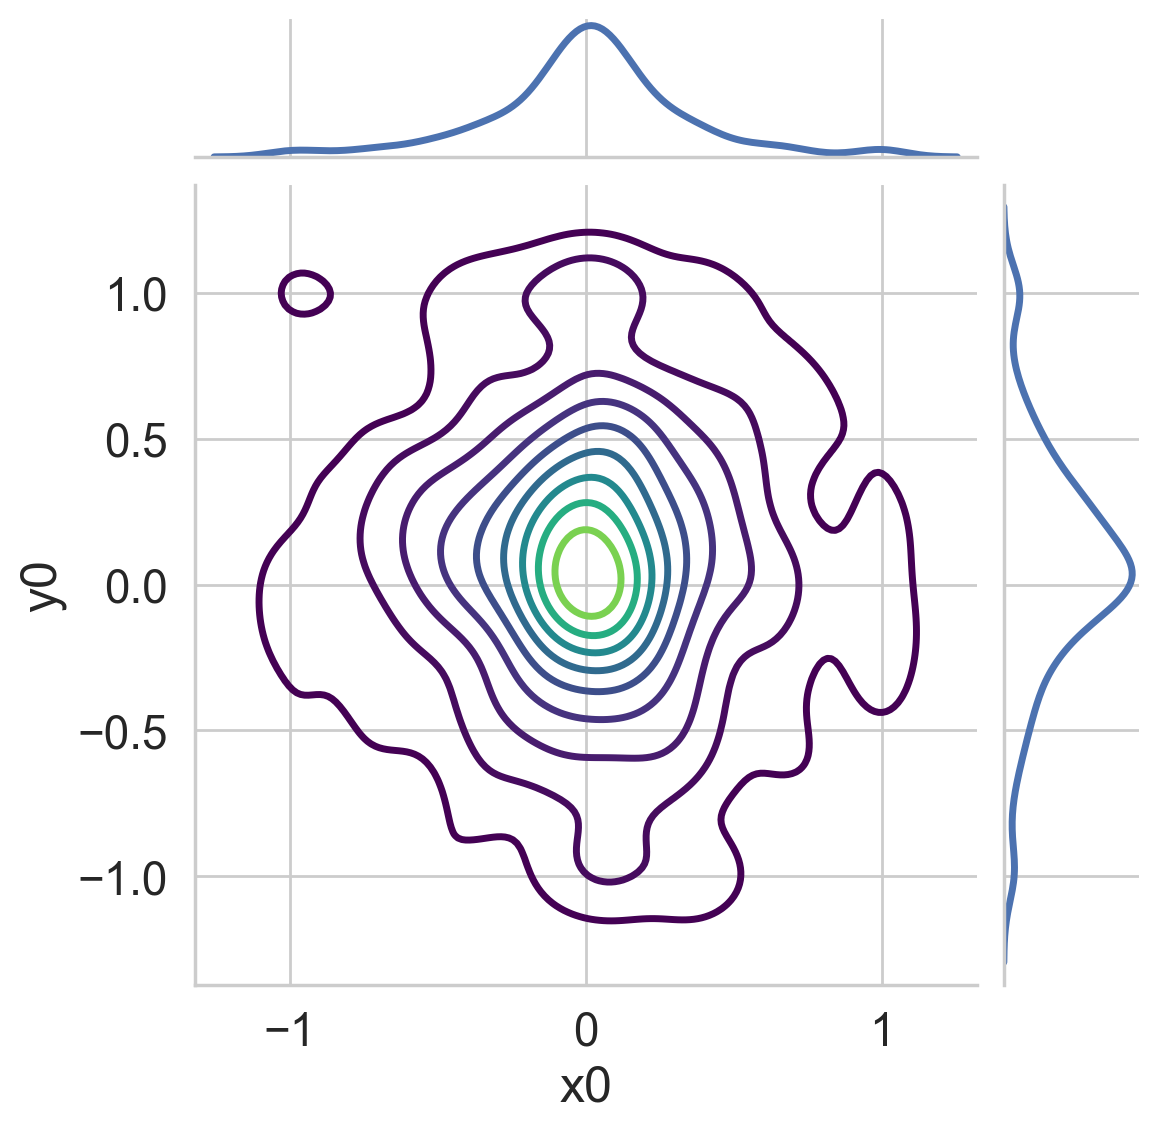

In [21]:
# Joint KDE plot with marginals
g = fovea.sns.jointplot(
    data=gaussian_df,
    x="x0",
    y="y0",
    kind="kde",
    cmap="viridis",
)
# plt.show()

/Users/laurentperrinet/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


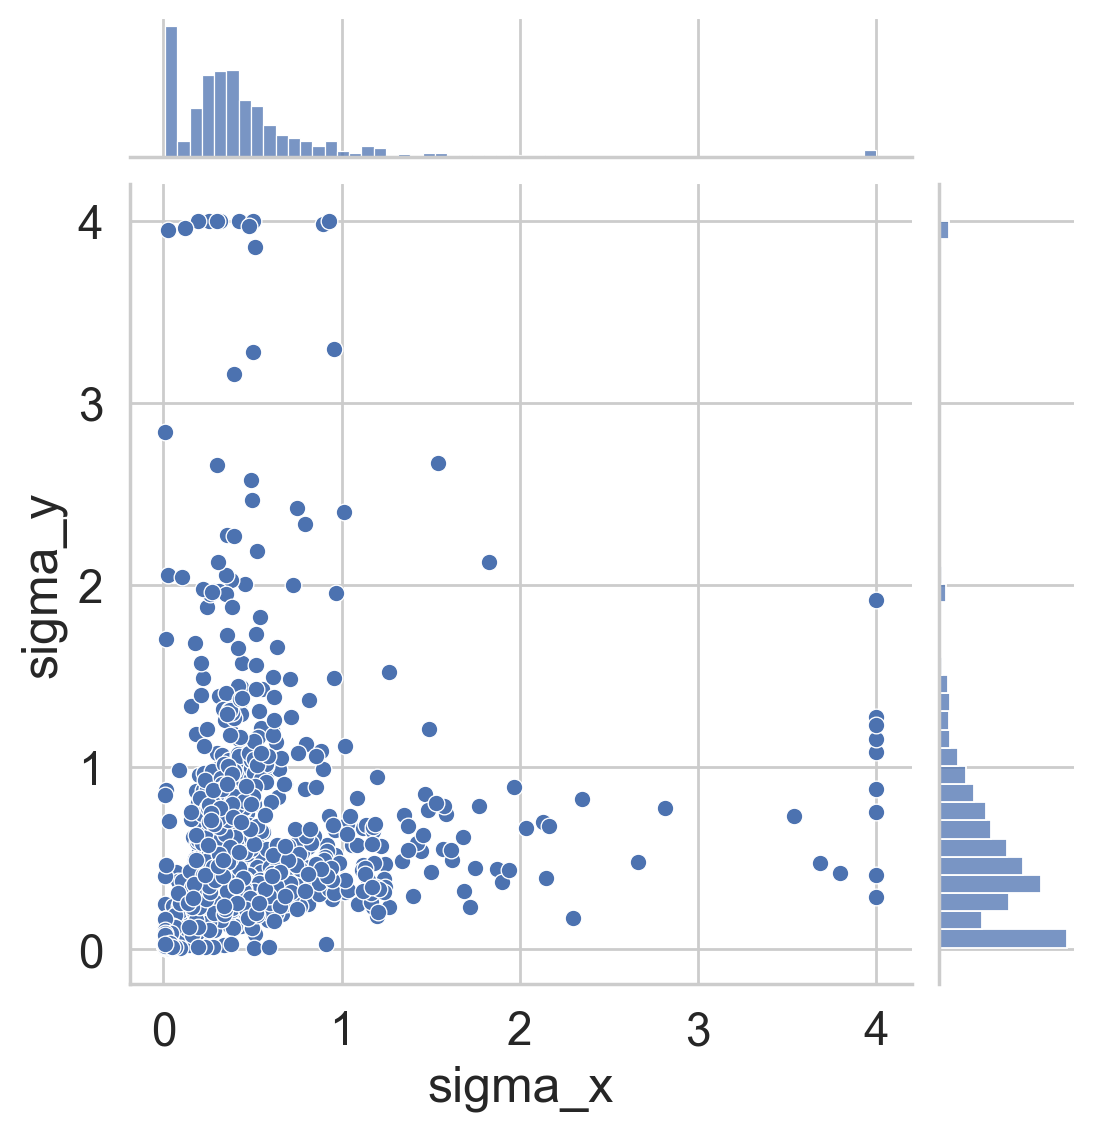

In [22]:
# Joint KDE plot with marginals
g = fovea.sns.jointplot(
    data=gaussian_df,
    x="sigma_x",
    y="sigma_y",
    kind="scatter",
    cmap="viridis",
)
# plt.show()

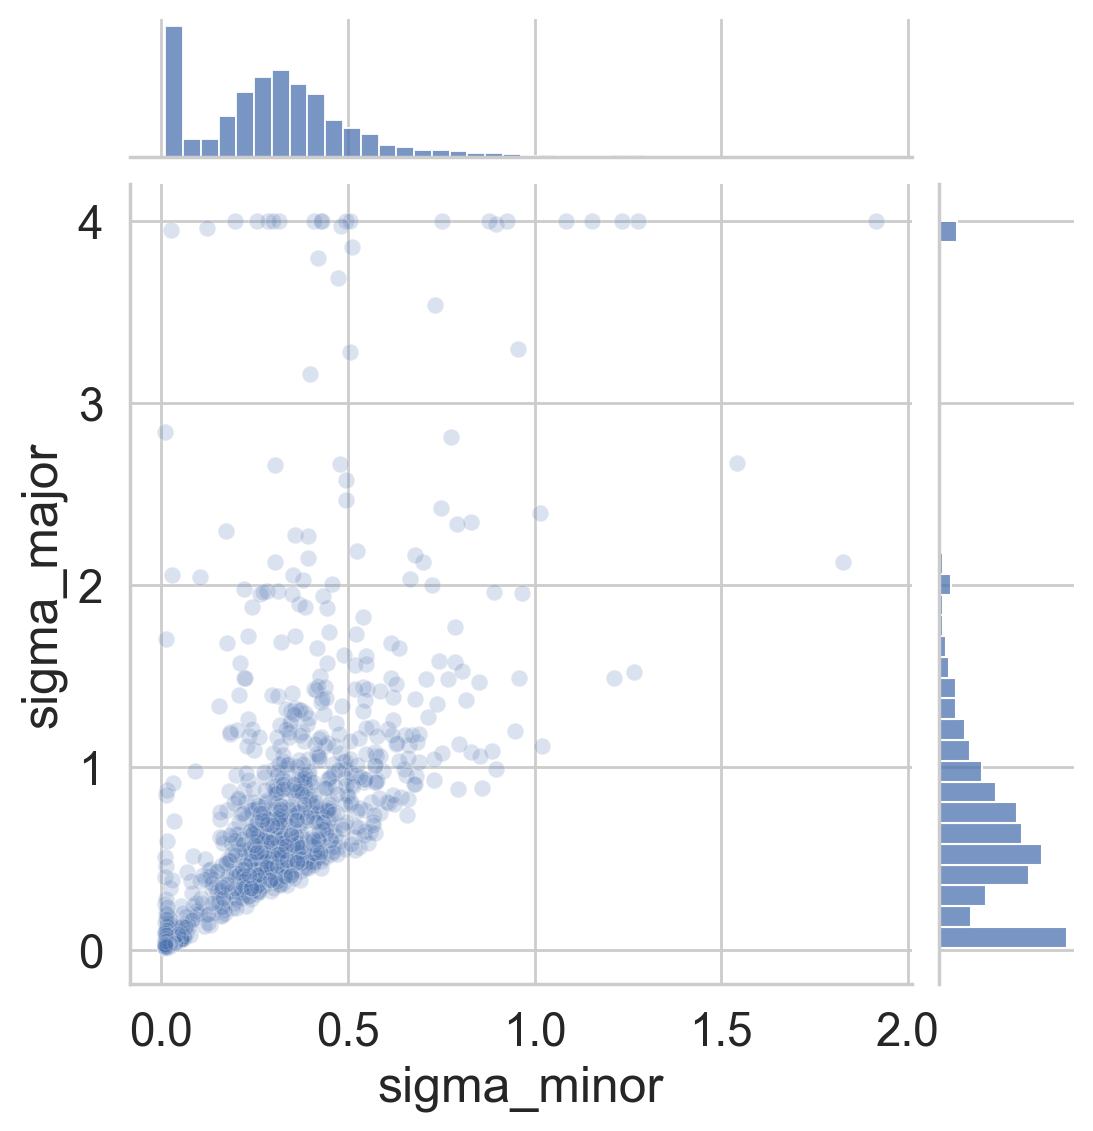

In [23]:
# Joint KDE plot with marginals
g = fovea.sns.jointplot(
    data=gaussian_df,
    x="sigma_minor",
    y="sigma_major",
    kind="scatter",
    alpha=.2,
)
# plt.show()

Text(1, 108, ' Peak @ 0.42')

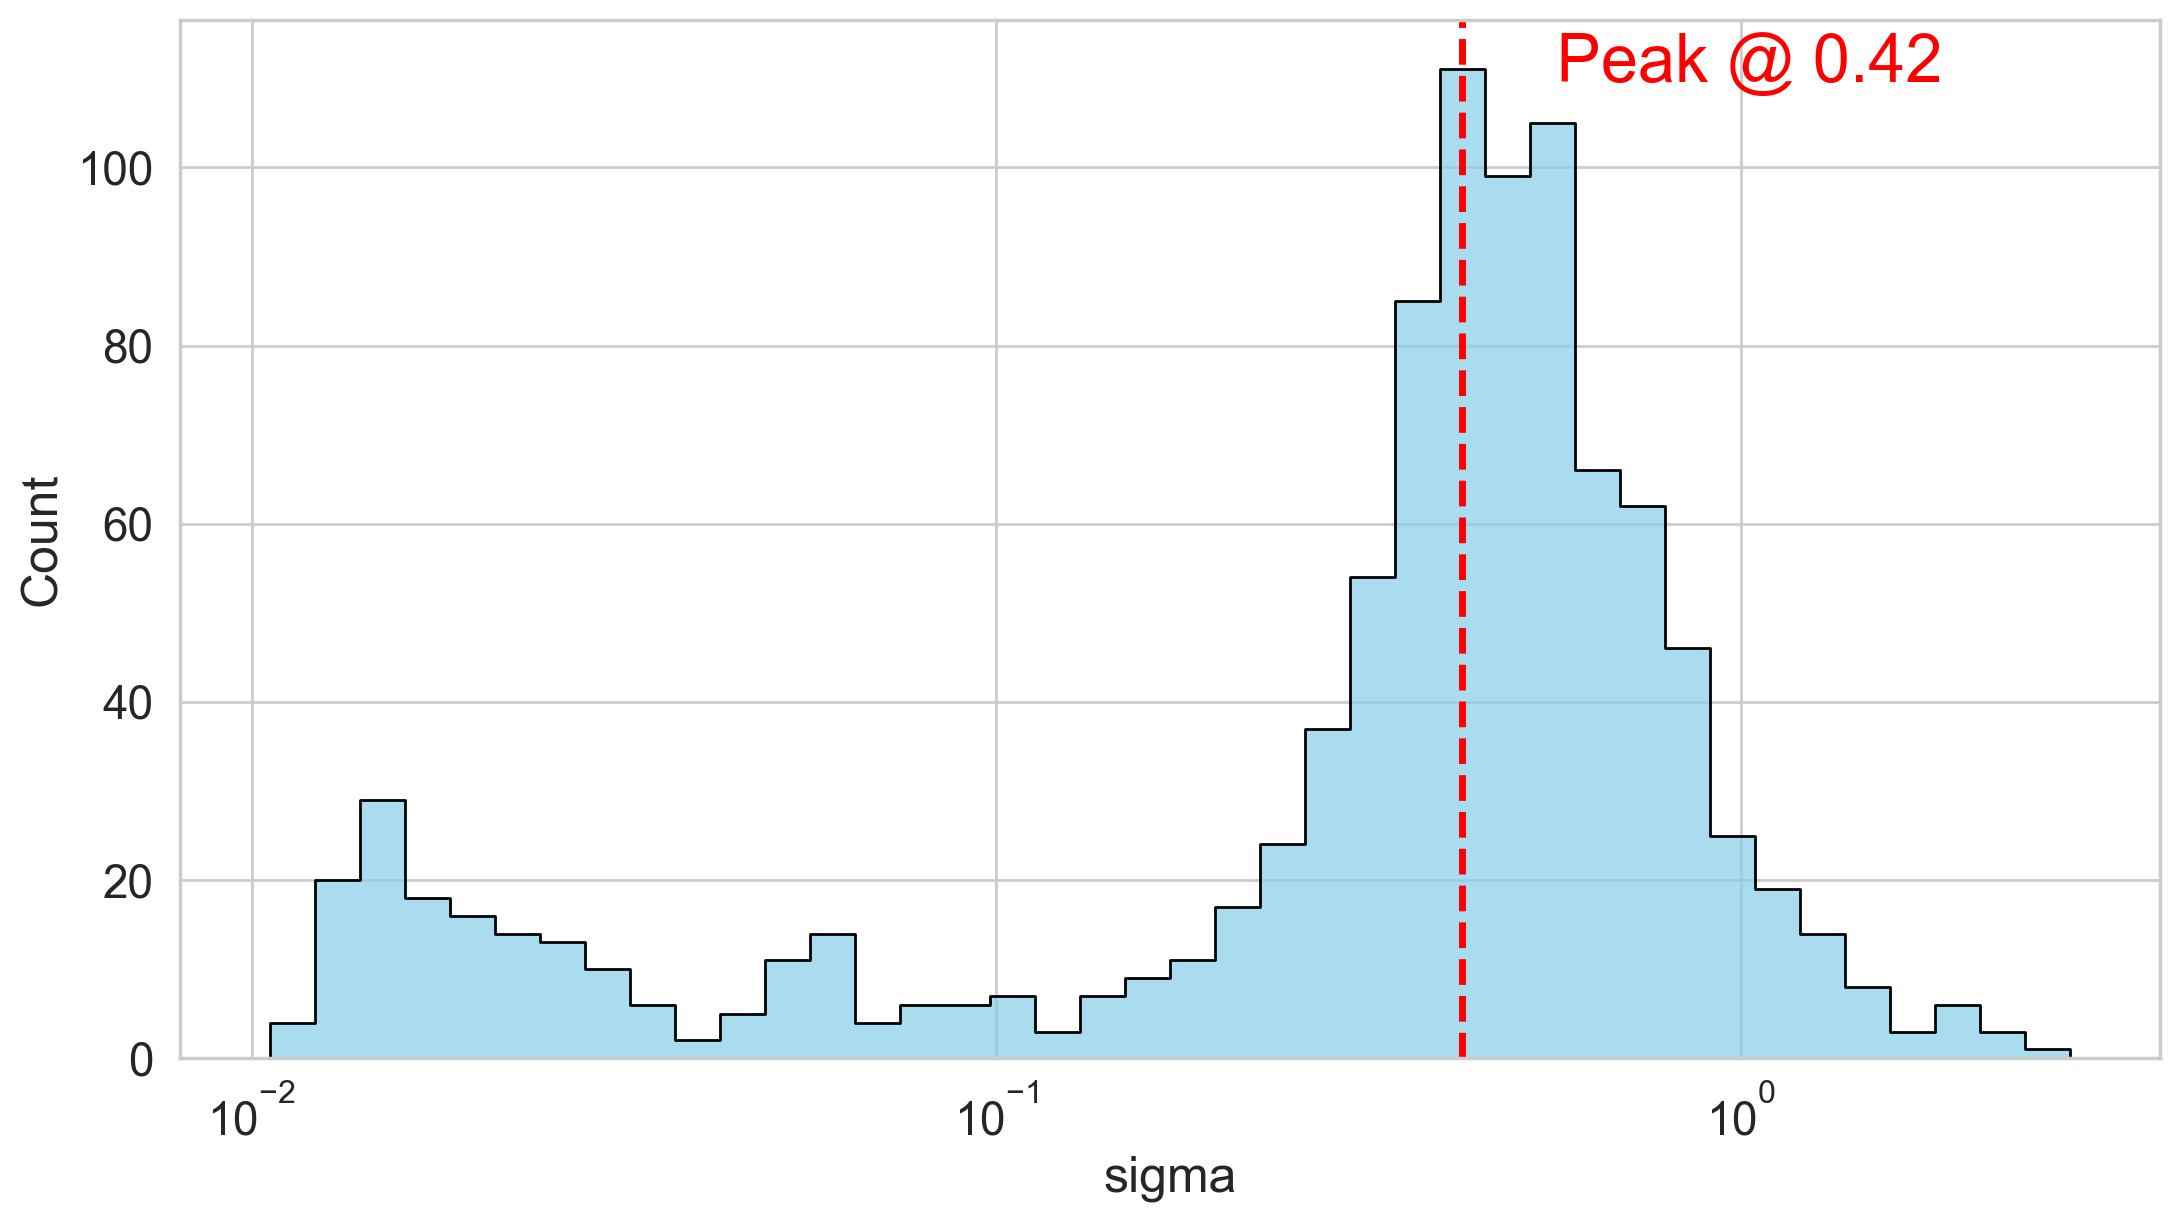

In [29]:
g = fovea.sns.histplot(
    data=gaussian_df,
    x='sigma',
    bins=40,
    element='step',  # Use step plots for clarity
    kde=False,  # Disable KDE for log-scaled x-axis
    color='skyblue',
    alpha=0.7,
    edgecolor='black',
    log_scale=(True, False)  # Log scale only for the x-axis
)

# Compute the peak (bin with the highest count)
counts, bin_edges = np.histogram(np.log(gaussian_df['sigma']), bins=40)
peak_bin_index = np.argmax(counts)
log_peak_value = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2  # Midpoint of the peak bin
peak_count = counts[peak_bin_index]
peak_value = np.exp(log_peak_value)

# Annotate the peak on the plot
fovea.plt.axvline(x=peak_value, color='red', linestyle='--', label=f'Peak: {peak_value:.2f}')
fovea.plt.text(
    1,
    108,
    f' Peak @ {peak_value:.2f}',
    ha='center',
    va='bottom',
    color='red',
    fontsize=24,
    bbox=dict(facecolor='white', alpha=0., edgecolor='none')
)

Text(4, 120, ' Peak @ 1.63')

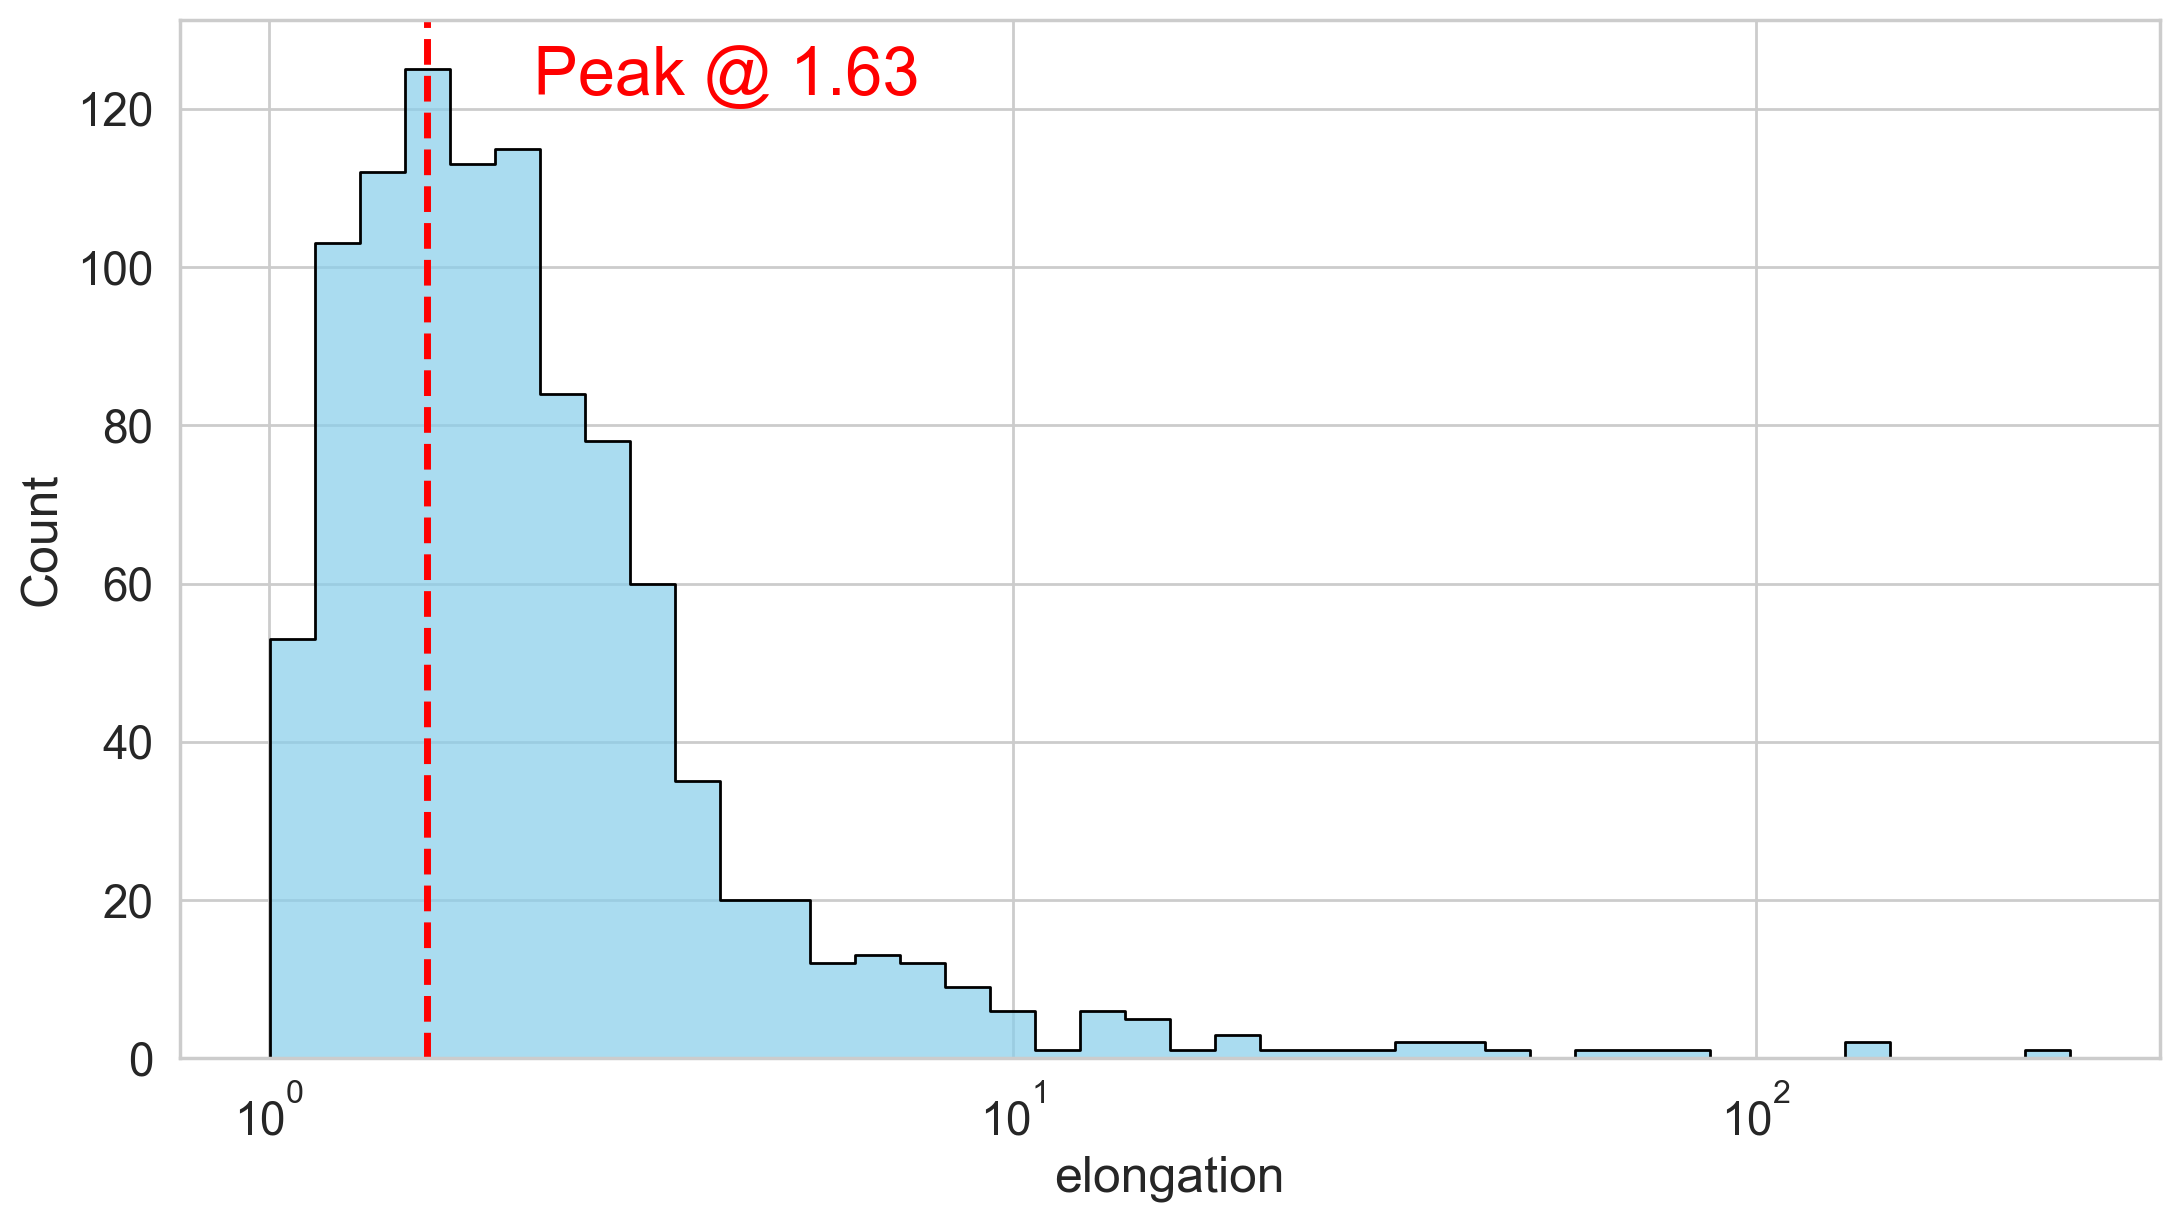

In [25]:
g = fovea.sns.histplot(
    data=gaussian_df,
    x='elongation',
    bins=40,
    element='step',  # Use step plots for clarity
    kde=False,  # Disable KDE for log-scaled x-axis
    color='skyblue',
    alpha=0.7,
    edgecolor='black',
    log_scale=(True, False)  # Log scale only for the x-axis
)

# Compute the peak (bin with the highest count)
counts, bin_edges = np.histogram(np.log(gaussian_df['elongation']), bins=40)
peak_bin_index = np.argmax(counts)
log_peak_value = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2  # Midpoint of the peak bin
peak_count = counts[peak_bin_index]
peak_value = np.exp(log_peak_value)

# Annotate the peak on the plot
fovea.plt.axvline(x=peak_value, color='red', linestyle='--', label=f'Peak: {peak_value:.2f}')
fovea.plt.text(
    4,
    120,
    f' Peak @ {peak_value:.2f}',
    ha='center',
    va='bottom',
    color='red',
    fontsize=24,
    bbox=dict(facecolor='white', alpha=0., edgecolor='none')
)

In [26]:
gaussian_df['elongation'].min(), gaussian_df['elongation'].max()

(np.float64(1.00195305188432), np.float64(264.2712518028279))

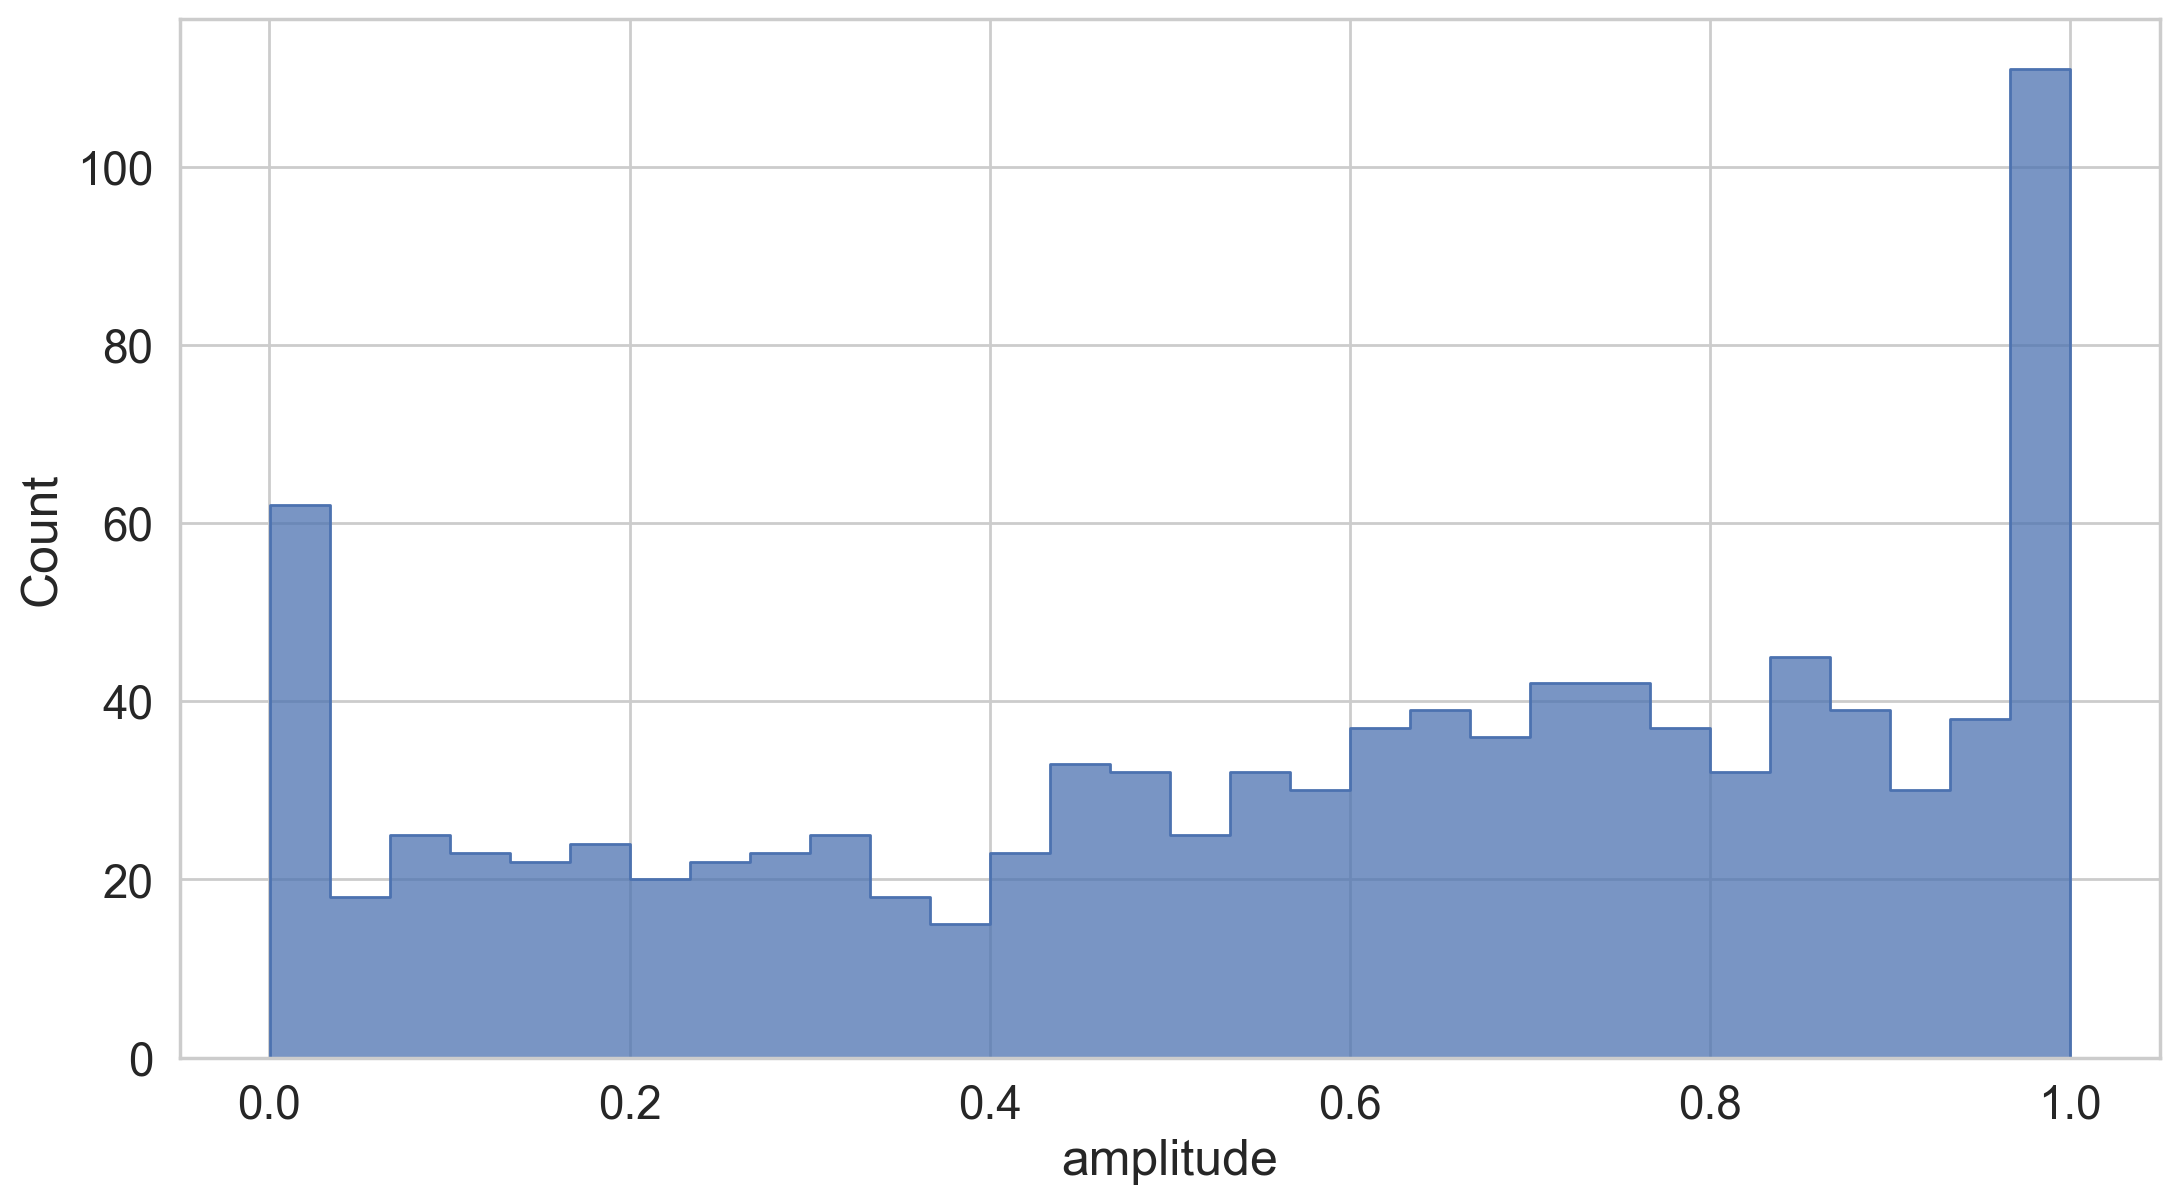

In [27]:
g = fovea.sns.histplot(
    data=gaussian_df,
    x='amplitude',
    bins=30,
    element='step'  # Use step plots for clarity
)


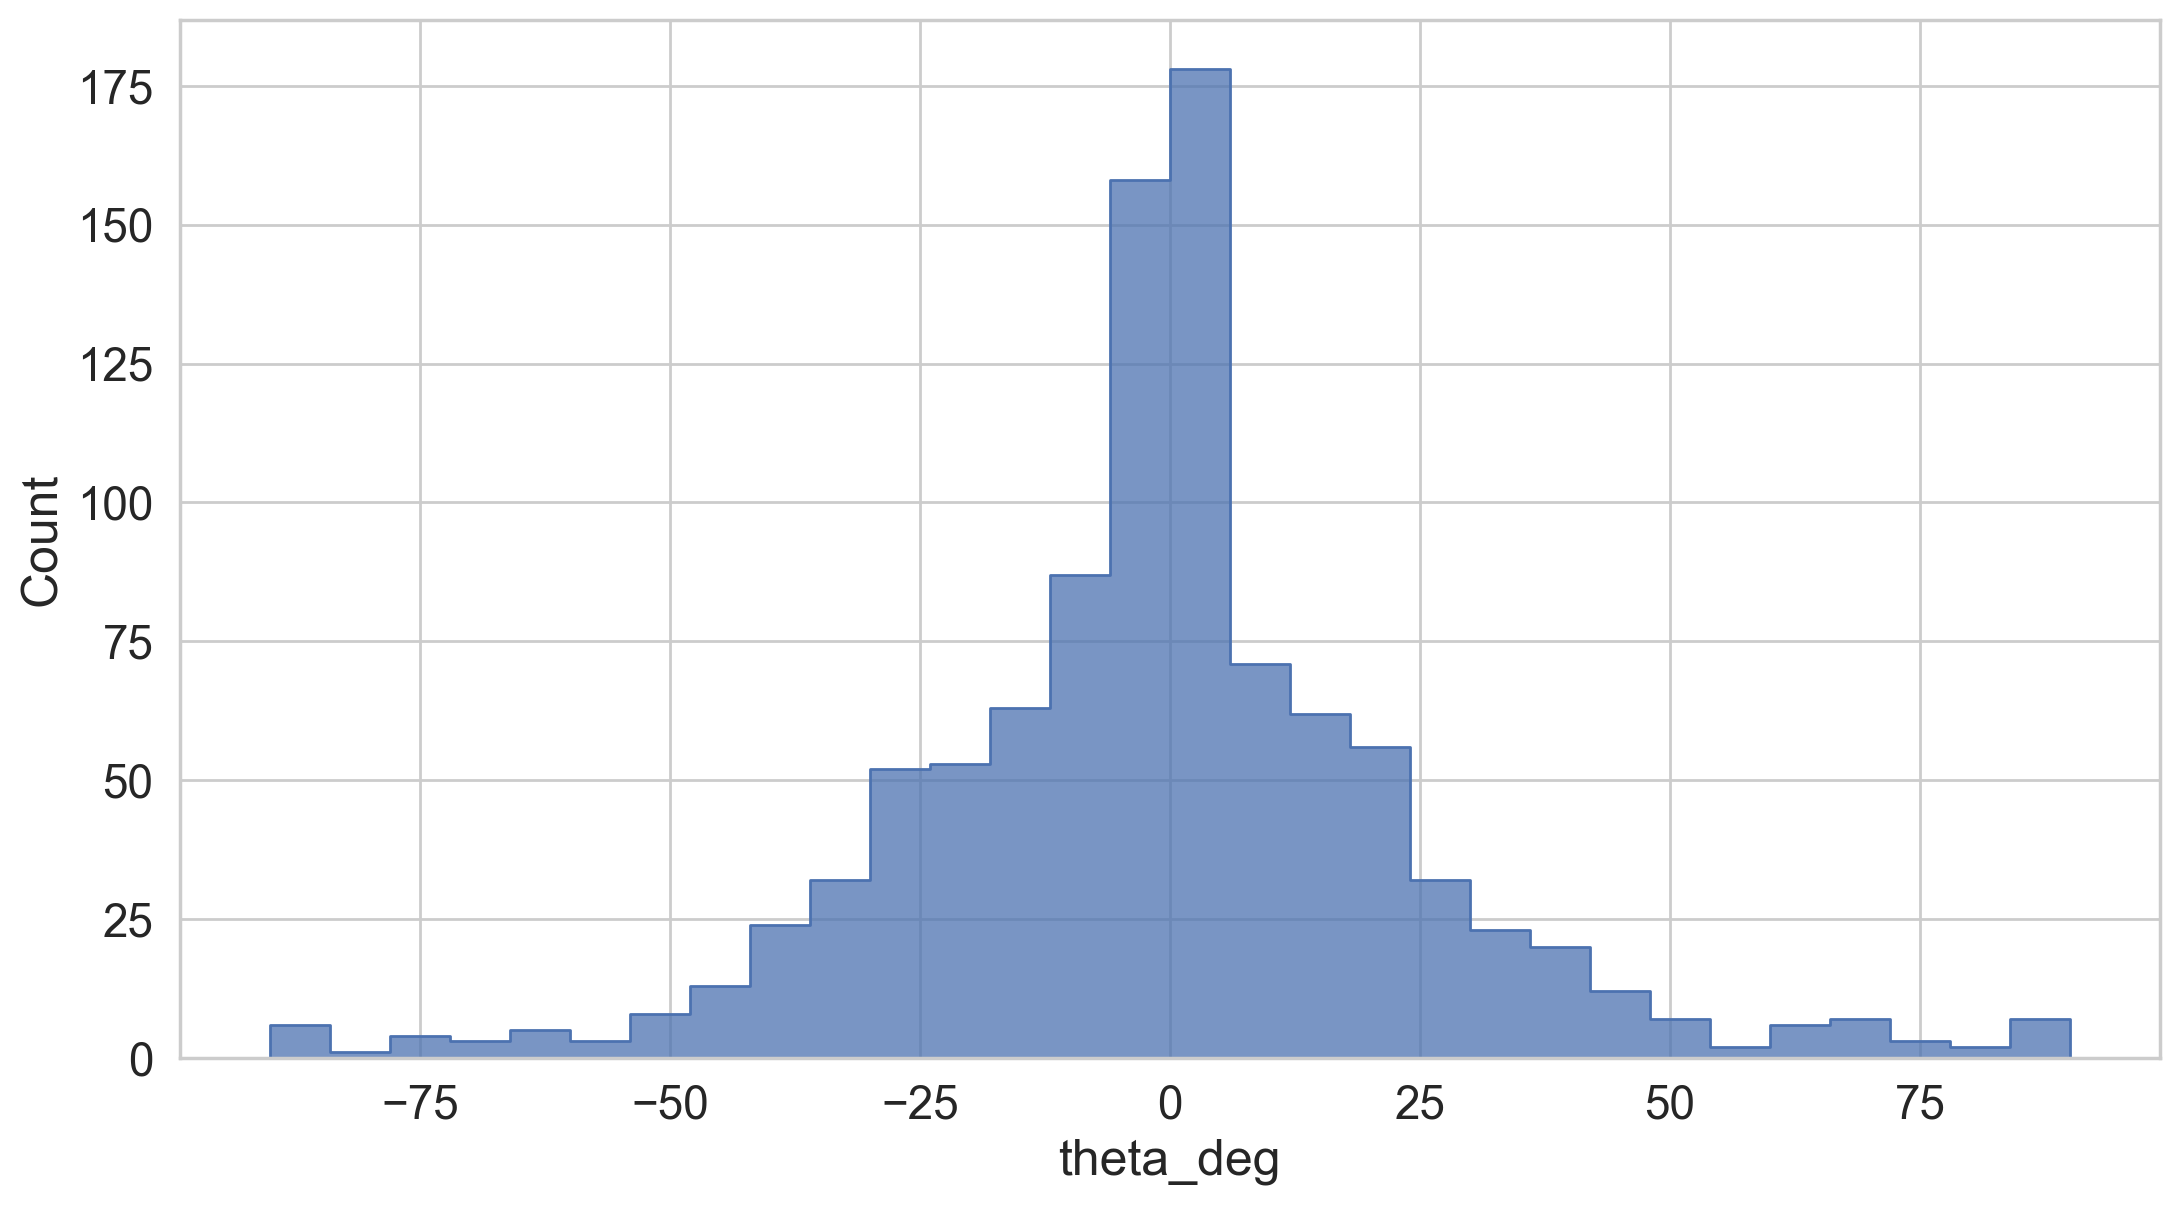

In [28]:
g = fovea.sns.histplot(
    data=gaussian_df,
    x='theta_deg',
    bins=30,
    element='step'  # Use step plots for clarity
)


Interpretation:

* θ=0: The major axis is aligned with the x-axis.
* θ=π/2: The major axis is aligned with the y-axis.
* θ=π/4: The major axis is at a 45° angle.


Voilà